## 1. Importación de bibliotecas y configuración inicial ##

In [1]:
# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder


import warnings

# Configuración inicial
pd.set_option('display.max_columns', None)  # Para mostrar todas las columnas del dataframe
warnings.filterwarnings('ignore')  # Para ignorar advertencias


## 2. Carga y exploración inicial de los datos ##

In [2]:
df = pd.read_excel(r"C:\Users\Usuari\Downloads\regression_data.xls")

Verificación de tipo de datos y conversión de variables categóricas

In [3]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [4]:

# Convertir 'zipcode' a tipo categórico
df['zipcode'] = df['zipcode'].astype('category')

# Verificar los tipos de datos
print(df.dtypes)



id                        int64
date             datetime64[ns]
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                category
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
price                     int64
dtype: object


Identificación de valores nulos y manejo de duplicados

In [5]:
# Verificación de valores nulos
df.isna().sum()

# Verificación de duplicados
duplicates = df[df.duplicated(subset='id', keep=False)]

# Si hay duplicados
if not duplicates.empty:
    df.drop_duplicates(subset='id', keep='first', inplace=True)


## 3. Análisis exploratorio de datos (EDA) ##

In [6]:
# Descripción estadística
df.describe()


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price
count,2.142000e+04,21420,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04
mean,4.580940e+09,2014-10-28 05:03:51.932773120,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.007610,0.235107,3.410784,7.662792,1791.170215,291.962418,1971.092997,84.793091,47.560197,-122.213784,1988.384080,12775.718161,5.407393e+05
min,1.000102e+06,2014-05-02 00:00:00,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123537e+09,2014-07-21 00:00:00,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,47.471200,-122.328000,1490.000000,5100.000000,3.225000e+05
50%,3.904921e+09,2014-10-15 00:00:00,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.572100,-122.230000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,2015-02-13 00:00:00,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,560.000000,1997.000000,0.000000,47.678100,-122.125000,2370.000000,10086.250000,6.450000e+05
max,9.900000e+09,2015-05-27 00:00:00,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06
std,2.876761e+09,NaN,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.086903,0.767165,0.650035,1.171971,828.692965,442.875502,29.387141,402.574626,0.138589,0.140791,685.537057,27345.621867,3.679311e+05


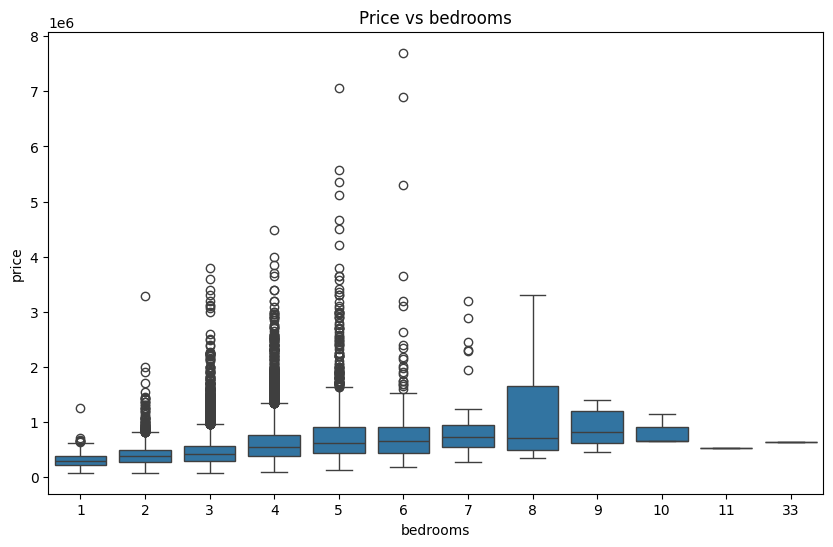

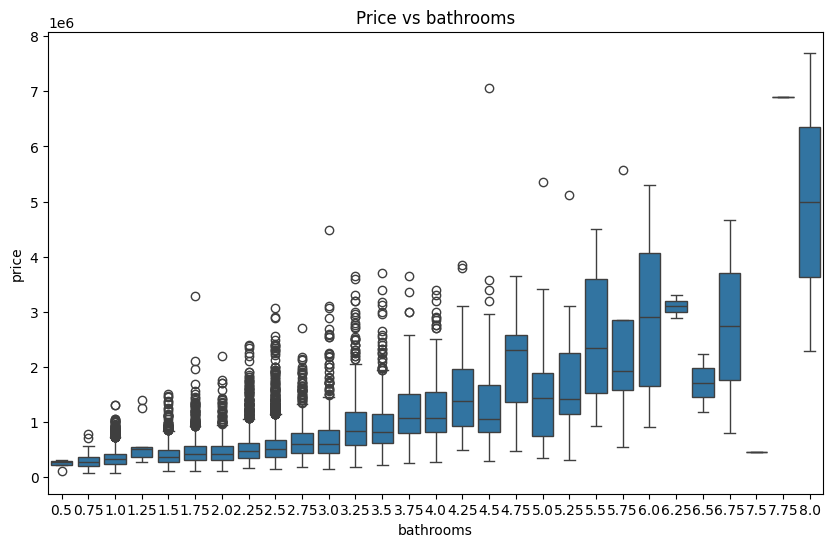

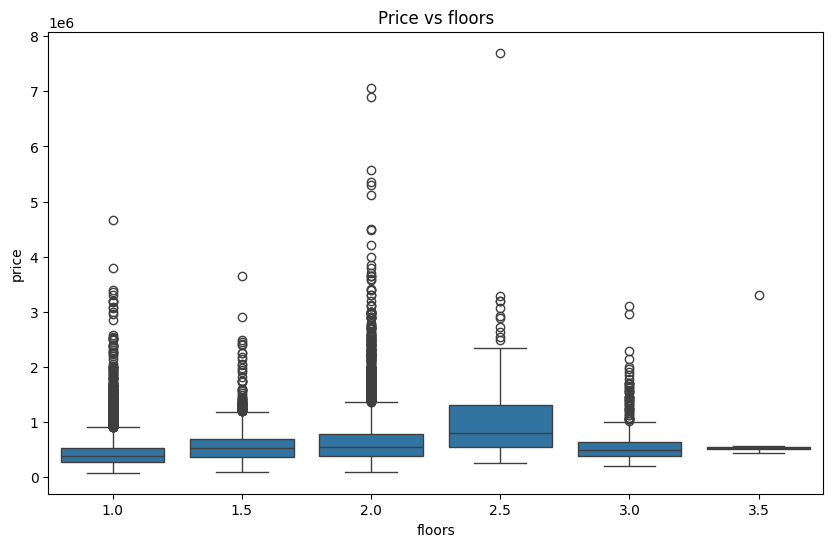

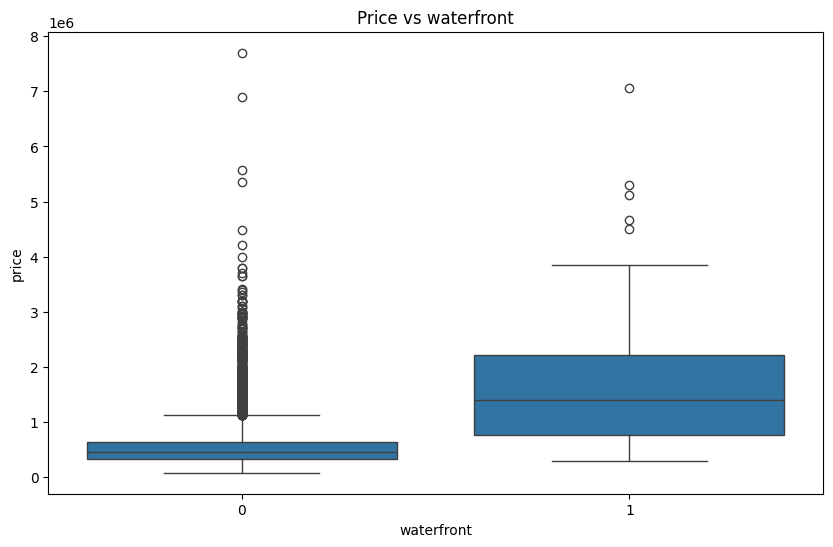

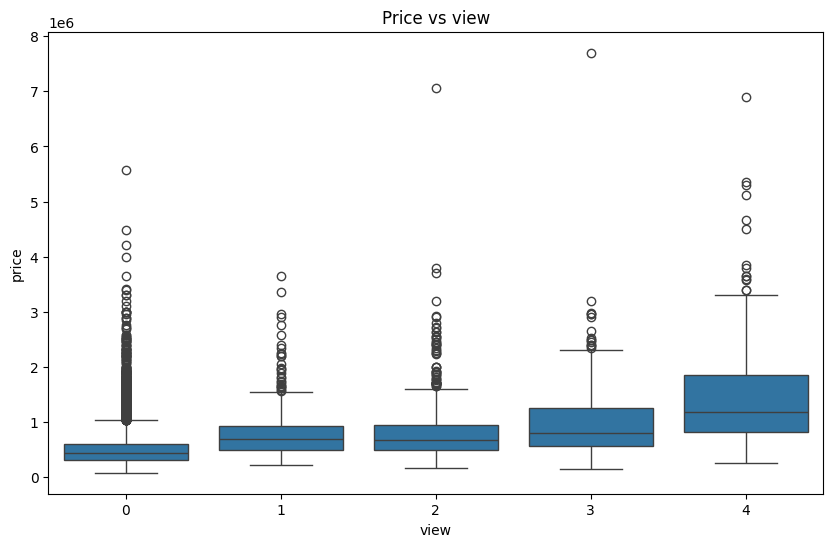

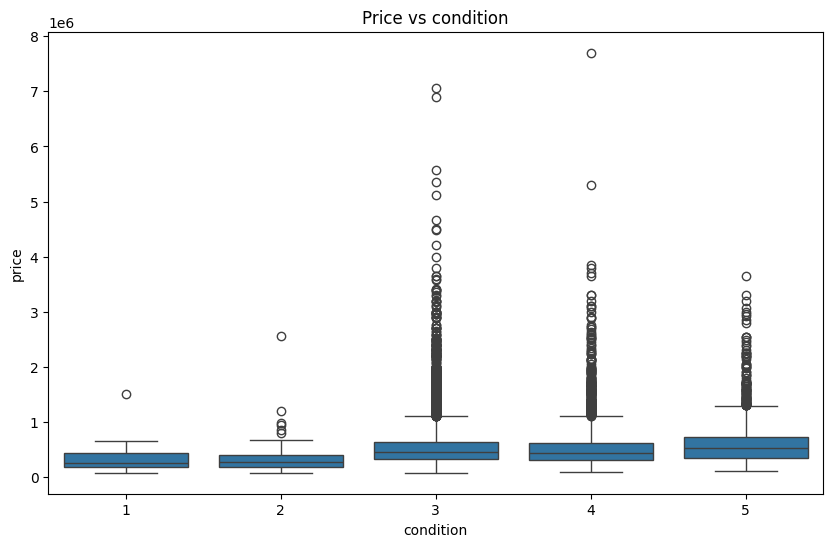

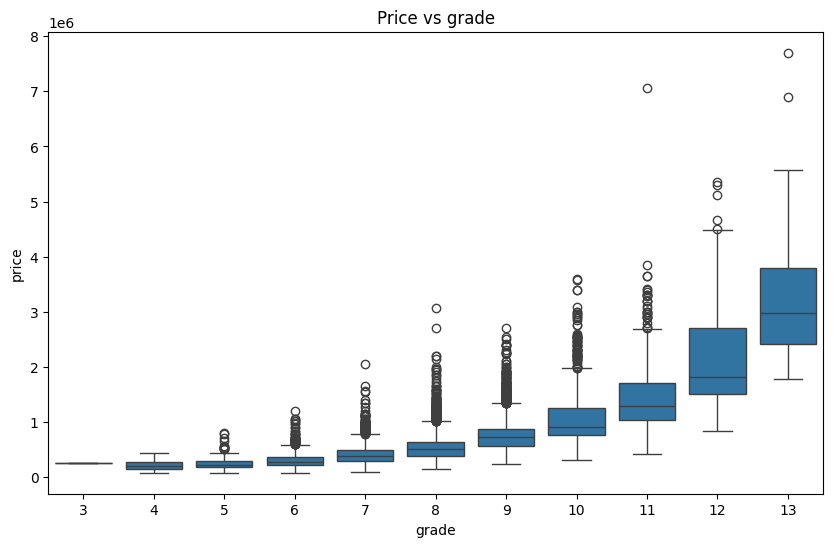

In [7]:
# Gráficos de variables categóricas en relación al precio
categorical_features = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='price', data=df)
    plt.title(f'Price vs {feature}')
    plt.show()


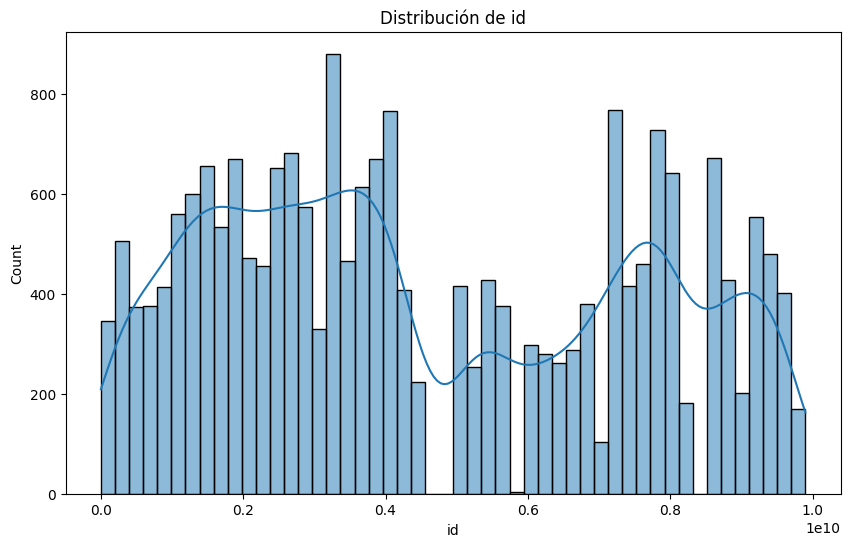

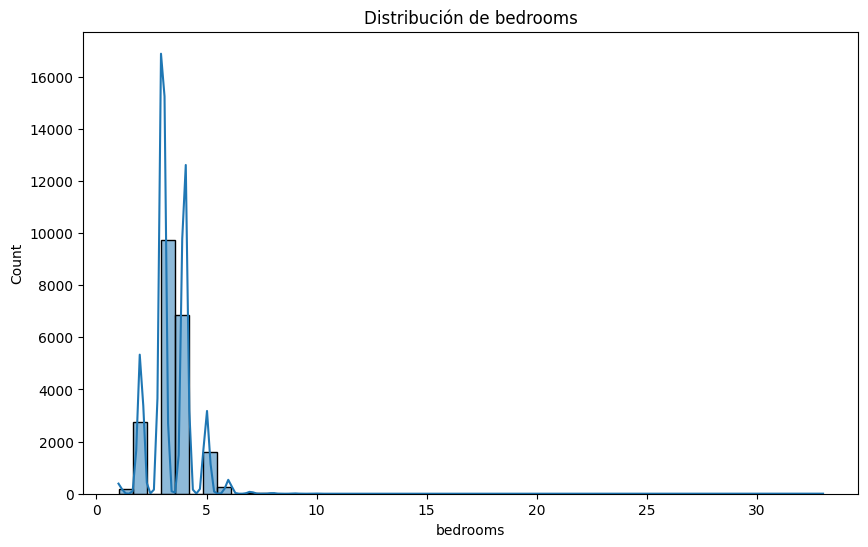

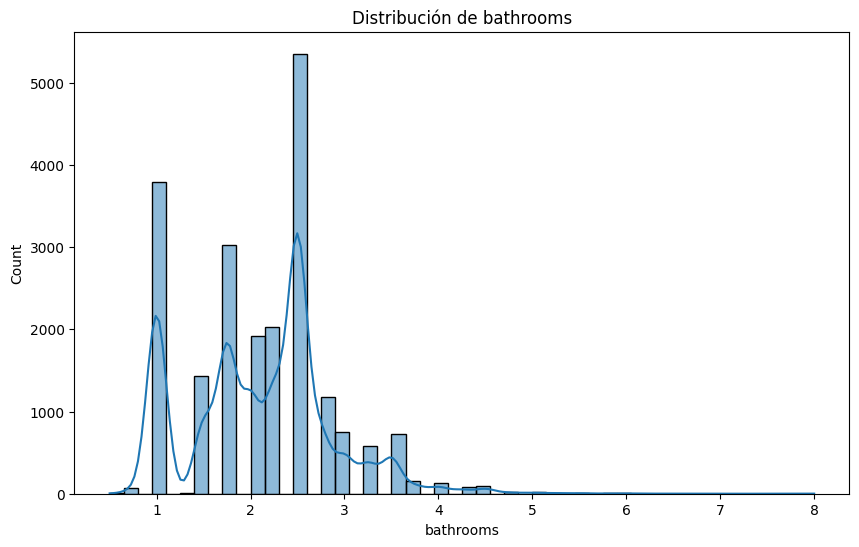

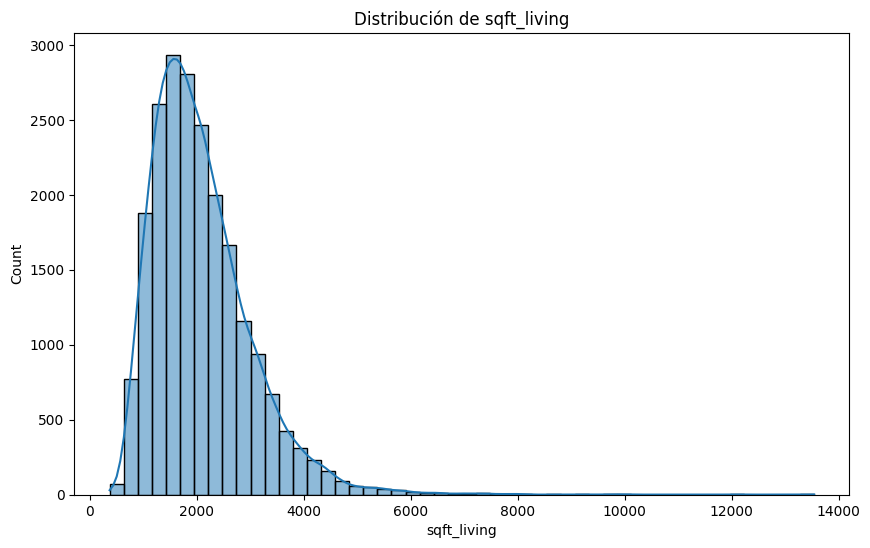

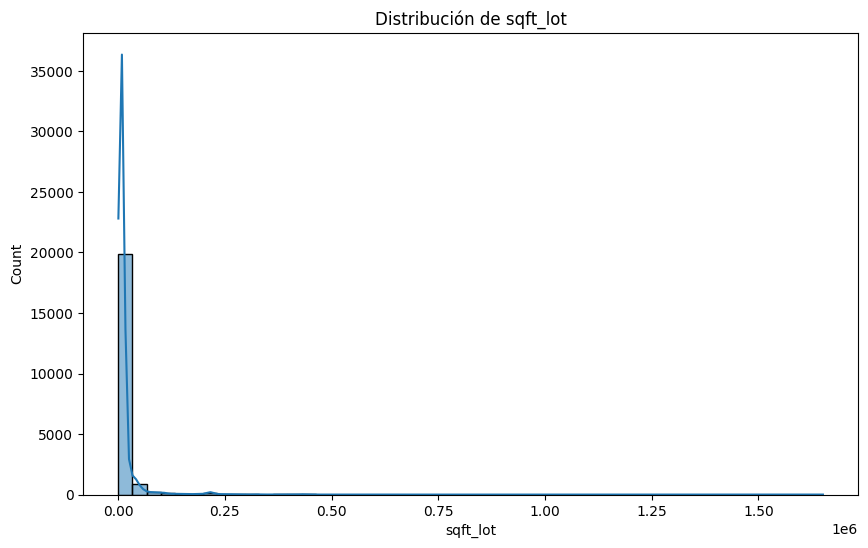

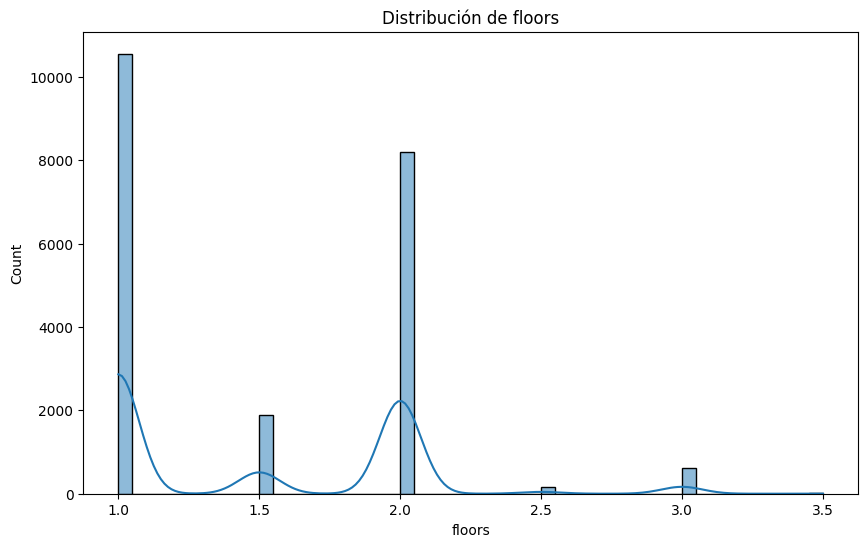

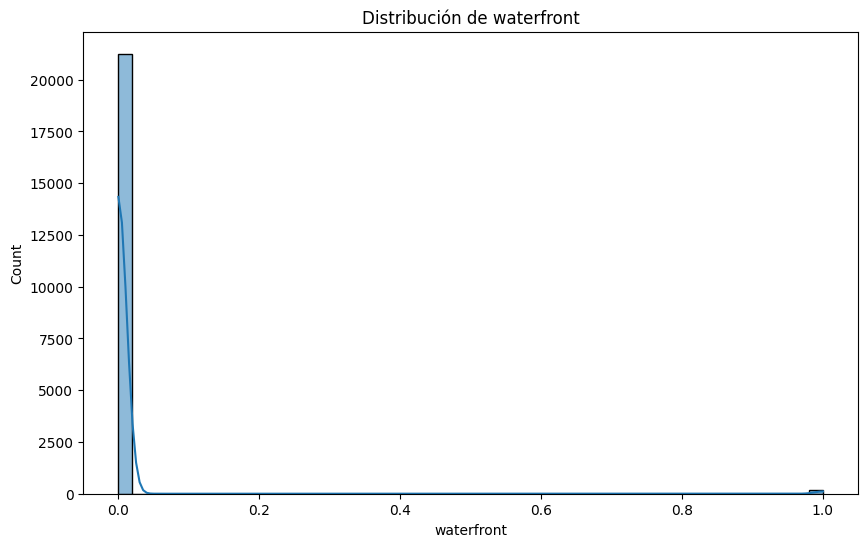

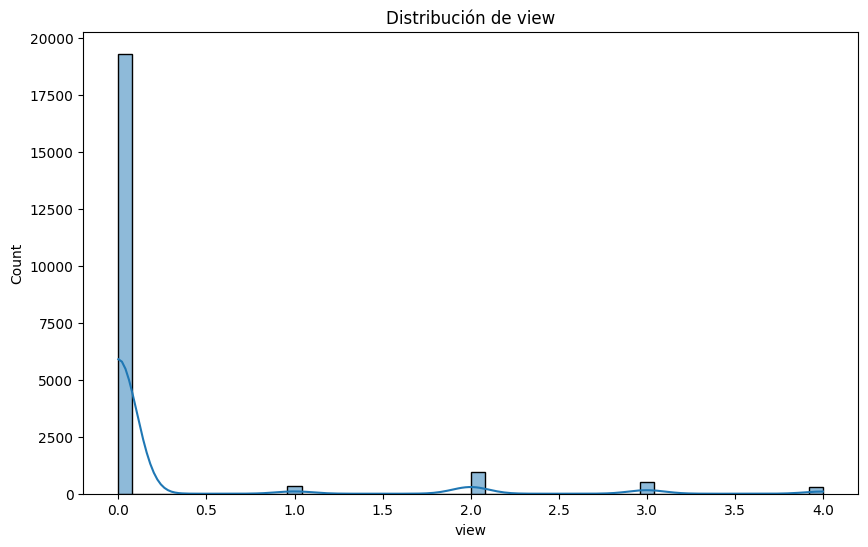

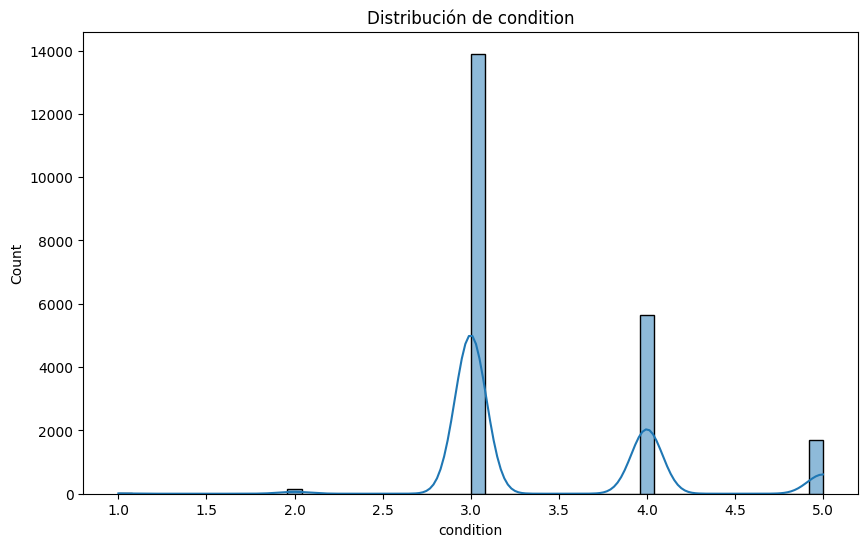

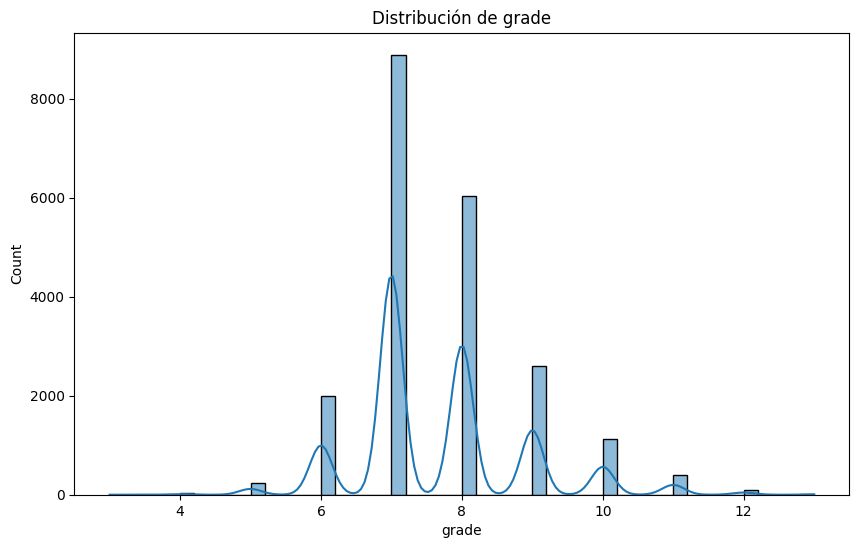

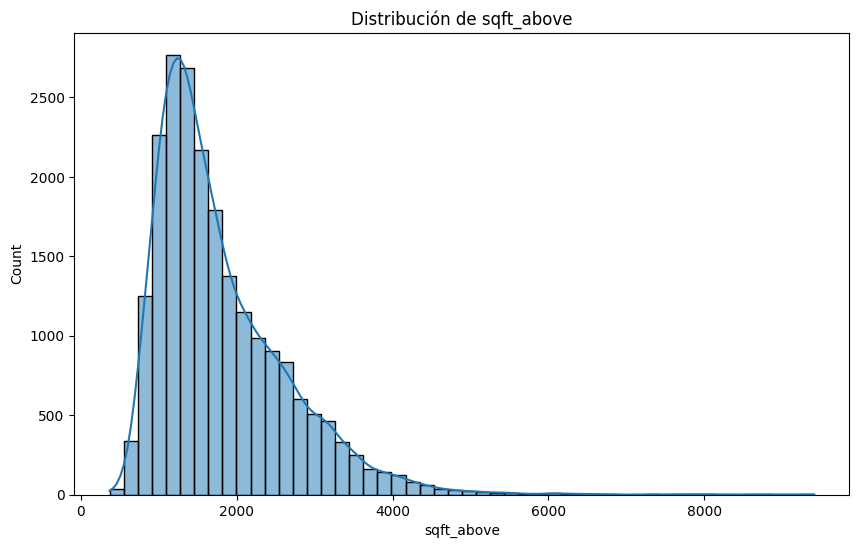

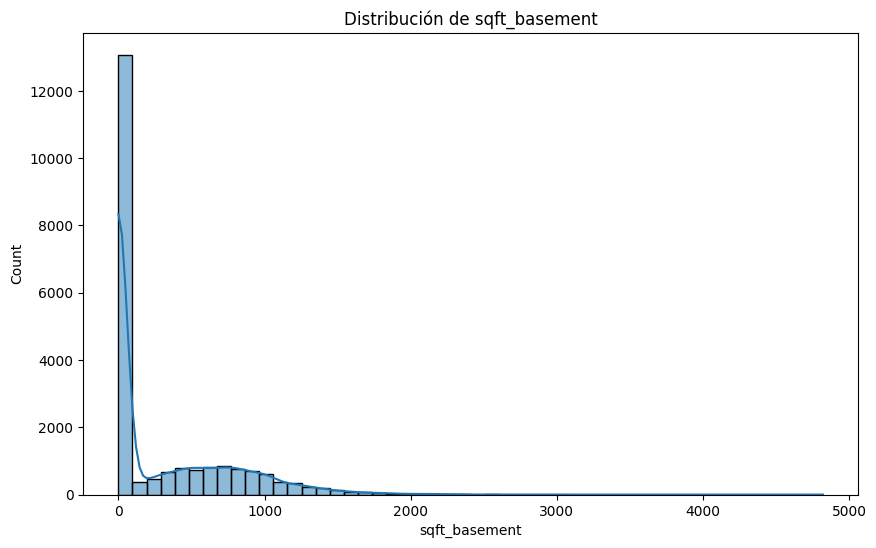

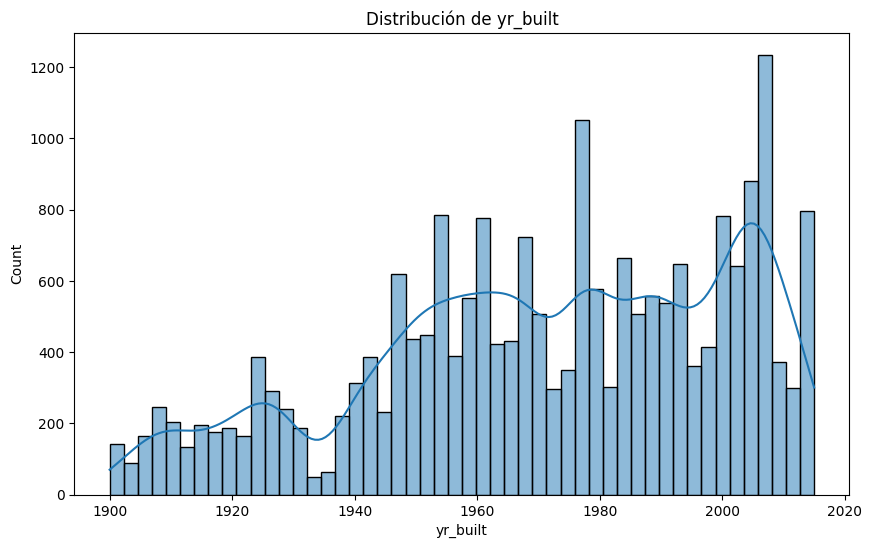

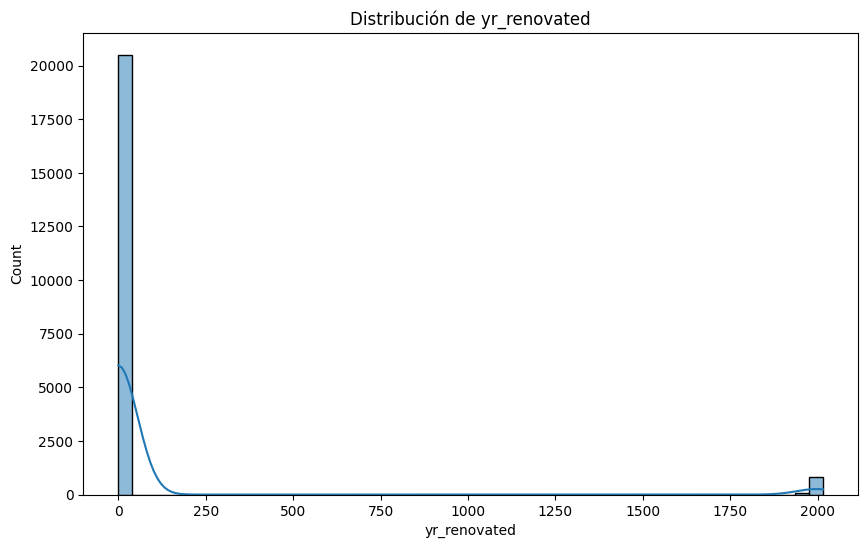

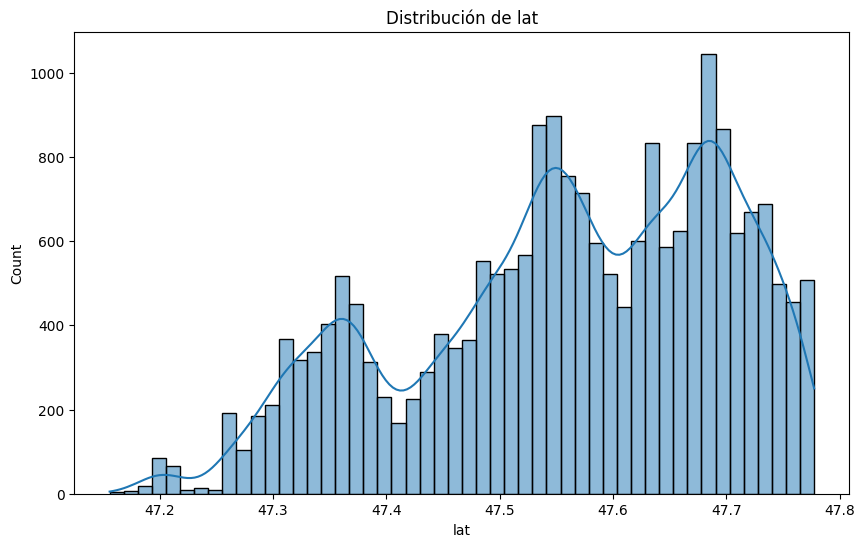

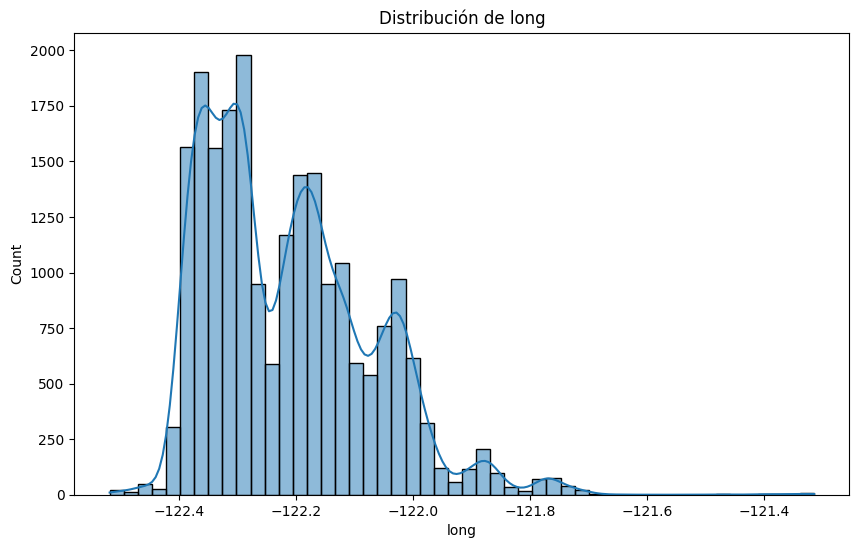

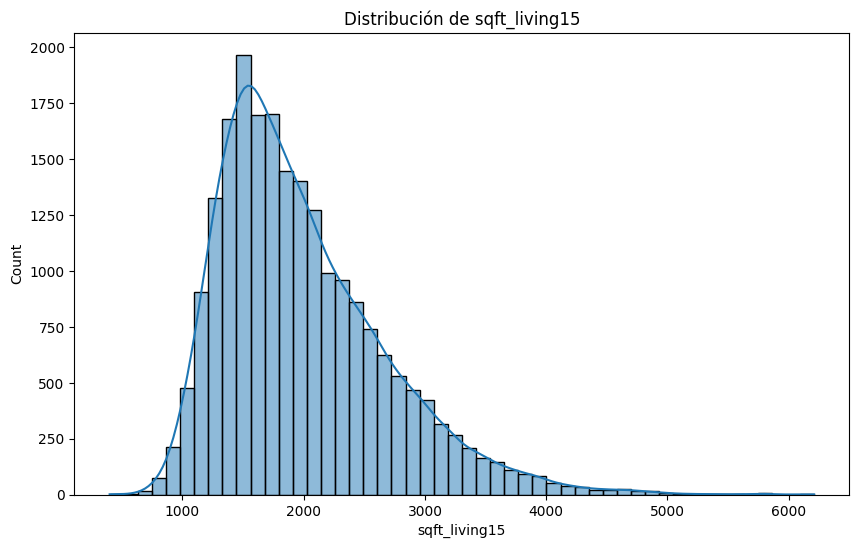

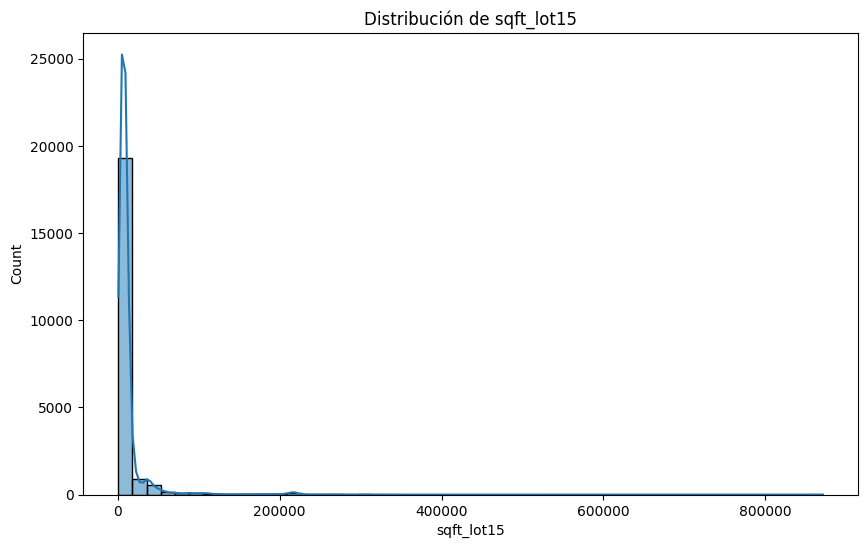

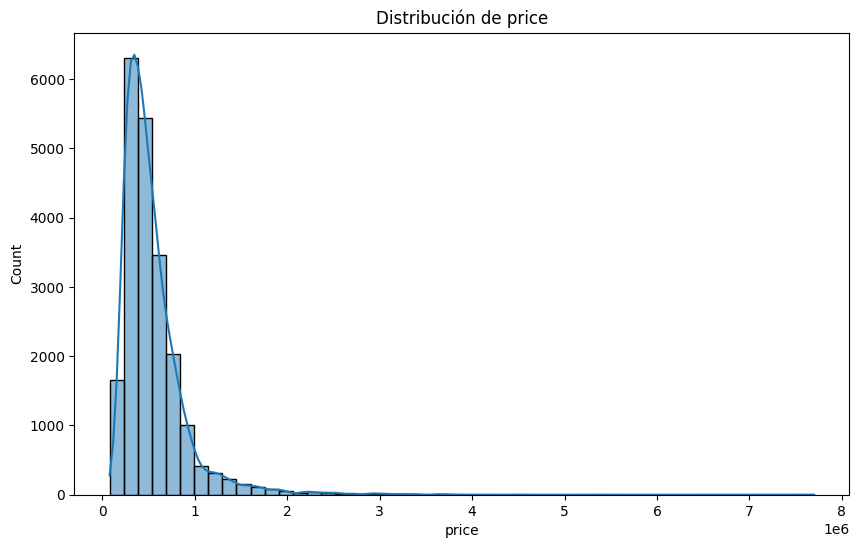

In [8]:
# Visualización de distribuciones
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()


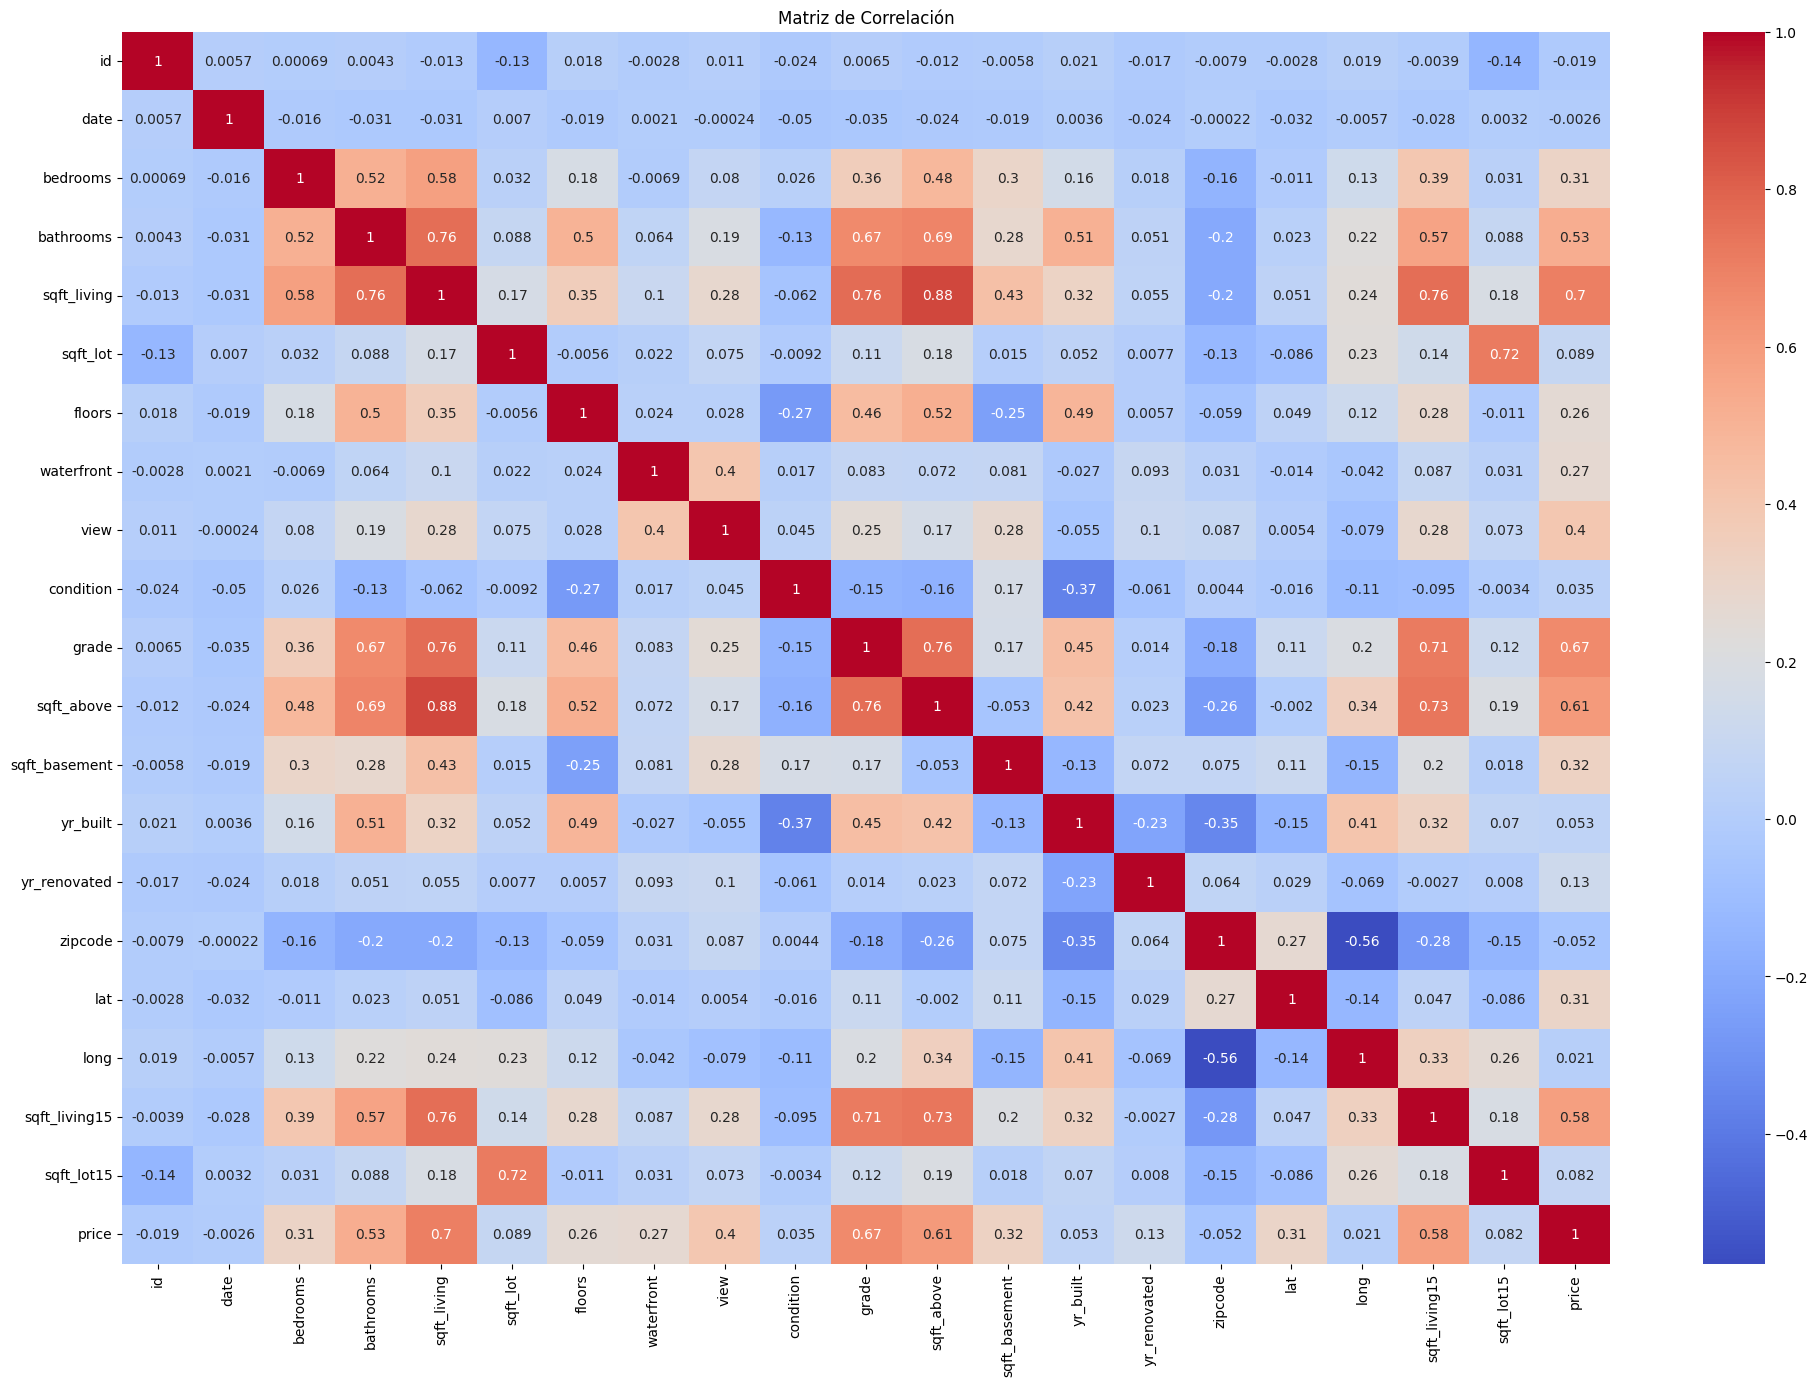

In [9]:
# Matriz de correlación
correlations_matrix = df.corr()
plt.figure(figsize=(24, 16))
sns.heatmap(correlations_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


### Resumen de análisis de datos y visualizaciones ###

##### 1. Análisis de variables categóricas #####

Price vs Bedrooms:

La gráfica de boxplot muestra la relación entre el precio de las viviendas y el número de dormitorios. Observamos que a medida que aumenta el número de dormitorios, la mediana del precio también tiende a aumentar. Sin embargo, hay outliers significativos, especialmente en casas con 6 o más dormitorios.

Price vs Bathrooms:

En esta gráfica de boxplot, se observa que a mayor número de baños, el precio de las viviendas tiende a ser más alto. Esto se alinea con la expectativa de que casas con más baños generalmente ofrecen mayor comodidad y, por lo tanto, son más costosas.

Price vs Floors:

La relación entre el precio y el número de pisos de la vivienda muestra que casas con 2 y 3 pisos tienden a ser más costosas en comparación con aquellas con un solo piso. Sin embargo, también hay variabilidad considerable y presencia de outliers.

Price vs Waterfront:

La presencia de una vista al agua (waterfront) tiene un impacto significativo en el precio de las viviendas. Las casas con vista al agua muestran precios considerablemente más altos en comparación con aquellas que no tienen esta característica.

Price vs View:

La cantidad de vista también afecta el precio. Las viviendas con mejor vista (valores más altos) tienden a tener precios más elevados, lo cual es consistente con la percepción de mayor valor estético y recreativo.

Price vs Condition:

El estado de la vivienda (condition) no muestra una gran variación en los precios a través de diferentes condiciones. La mayoría de las viviendas están en condiciones promedio (3) con una distribución de precios bastante amplia.

Price vs Grade:

El grado de calidad de la vivienda (grade) tiene una clara relación con el precio. A medida que aumenta el grado, también lo hace el precio de las viviendas, indicando que las viviendas de mayor calidad son significativamente más costosas.

##### 2. Análisis de distribuciones ######

Distribución de Bedrooms:

La mayoría de las viviendas tienen entre 3 y 4 dormitorios, con una distribución sesgada a la derecha, indicando la presencia de outliers con un número de dormitorios mucho mayor.

Distribución de Bathrooms:

La mayoría de las casas tienen entre 1 y 2.5 baños. La distribución es también sesgada a la derecha, mostrando algunas casas con un número significativamente mayor de baños.

Distribución de sqft_living:

La superficie habitable (sqft_living) tiene una distribución sesgada a la derecha, con la mayoría de las casas teniendo entre 1,000 y 3,000 pies cuadrados.

Distribución de sqft_lot:

La superficie del lote (sqft_lot) muestra una distribución altamente sesgada a la derecha, con la mayoría de los lotes siendo relativamente pequeños y algunos outliers con superficies extremadamente grandes.

Distribución de Floors:

La mayoría de las viviendas tienen 1 o 2 pisos, con una pequeña cantidad teniendo 1.5 o 3 pisos.

Distribución de Waterfront:

La mayoría de las viviendas no tienen vista al agua, lo que se refleja en la distribución altamente sesgada hacia 0.

Distribución de View:

La mayoría de las viviendas tienen un valor de vista de 0, indicando que no tienen vistas especiales. Pocas viviendas tienen mejores vistas (valores 1 a 4).

Distribución de Condition:

La mayoría de las viviendas están en condición promedio (3), con algunas en mejores o peores condiciones.

Distribución de Grade:

La calidad de las viviendas (grade) está distribuida alrededor de valores medios, con picos en los grados 7 y 8.

Distribución de sqft_above:

La superficie habitable sobre el suelo (sqft_above) tiene una distribución similar a la de sqft_living, también sesgada a la derecha.

Distribución de sqft_basement:

La mayoría de las viviendas no tienen sótano o tienen sótanos pequeños, lo que se refleja en la distribución sesgada a la derecha.

Distribución de yr_built:

La distribución del año de construcción muestra picos en varias décadas, reflejando diferentes períodos de desarrollo inmobiliario.

Distribución de yr_renovated:

La mayoría de las viviendas no han sido renovadas recientemente, como se muestra en la distribución sesgada a la derecha.

Distribución de lat y long:

Las distribuciones de latitud y longitud muestran la concentración de viviendas en áreas específicas del condado.

Distribución de sqft_living15 y sqft_lot15:

Las distribuciones de estas variables muestran una tendencia similar a las de sqft_living y sqft_lot, reflejando las renovaciones y cambios en las viviendas en 2015.

Distribución de Price:

El precio de las viviendas tiene una distribución sesgada a la derecha, con la mayoría de los precios concentrados en el rango más bajo y algunos outliers con precios extremadamente altos.

##### 3. Matriz de correlación #####

La matriz de correlación muestra relaciones significativas entre varias características y el precio de las viviendas. Destacan las altas correlaciones entre el precio y las variables sqft_living, grade, y sqft_above. Estas relaciones indican que el tamaño y la calidad de la vivienda son factores clave en la determinación del precio.

## 4. Transformación de datos ##

In [10]:

# Función para identificar outliers
def identificar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]
    return outliers

# Variables numéricas
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Identificar outliers en cada columna numérica
outliers_dict = {}
for columna in columnas_numericas:
    outliers_dict[columna] = identificar_outliers(df, columna)

# Mostrar el número de outliers por columna
for columna, outliers in outliers_dict.items():
    print(f"{columna}: {len(outliers)} outliers")


id: 0 outliers
bedrooms: 518 outliers
bathrooms: 558 outliers
sqft_living: 568 outliers
sqft_lot: 2406 outliers
floors: 0 outliers
waterfront: 163 outliers
view: 2114 outliers
condition: 28 outliers
grade: 1889 outliers
sqft_above: 600 outliers
sqft_basement: 493 outliers
yr_built: 0 outliers
yr_renovated: 910 outliers
lat: 2 outliers
long: 252 outliers
sqft_living15: 503 outliers
sqft_lot15: 2174 outliers
price: 1151 outliers


Hemos encontrado outliers en varias características que pueden ser importantes, así que vamos a aplicar una transformación logarítmica.

Tratamiento de los outliers: transformación logarítmica

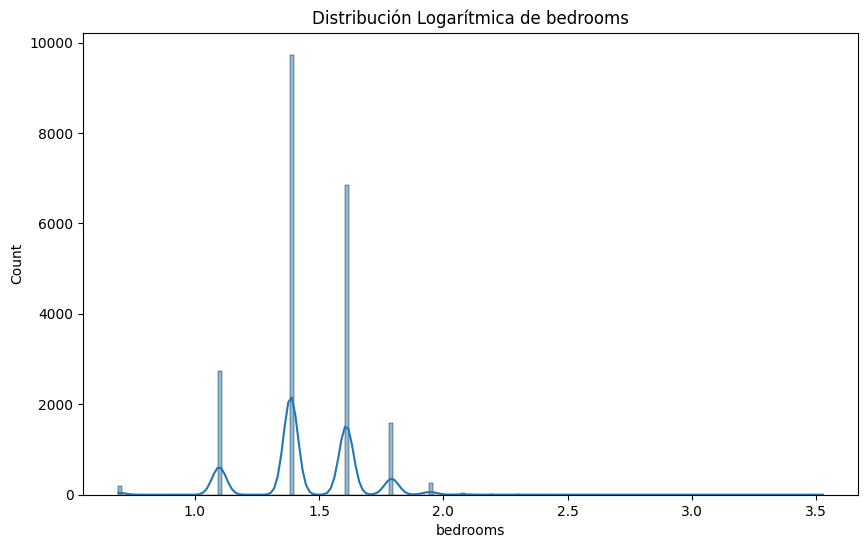

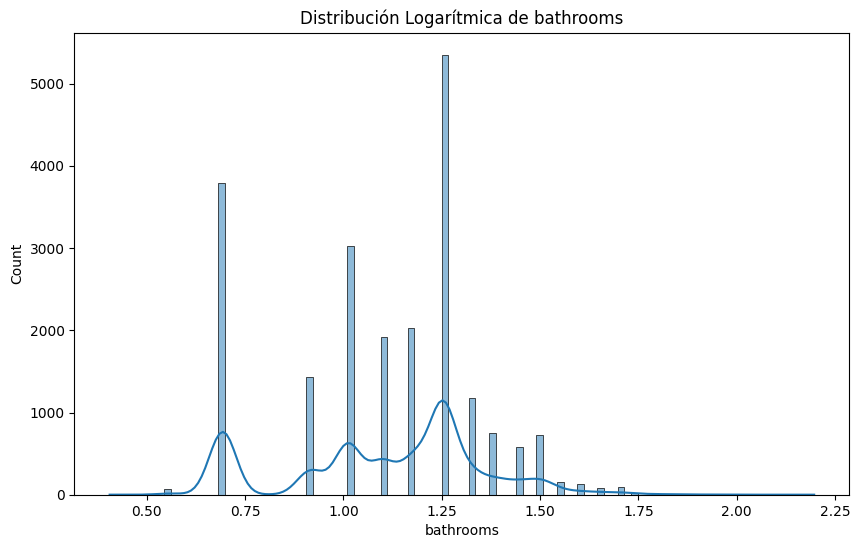

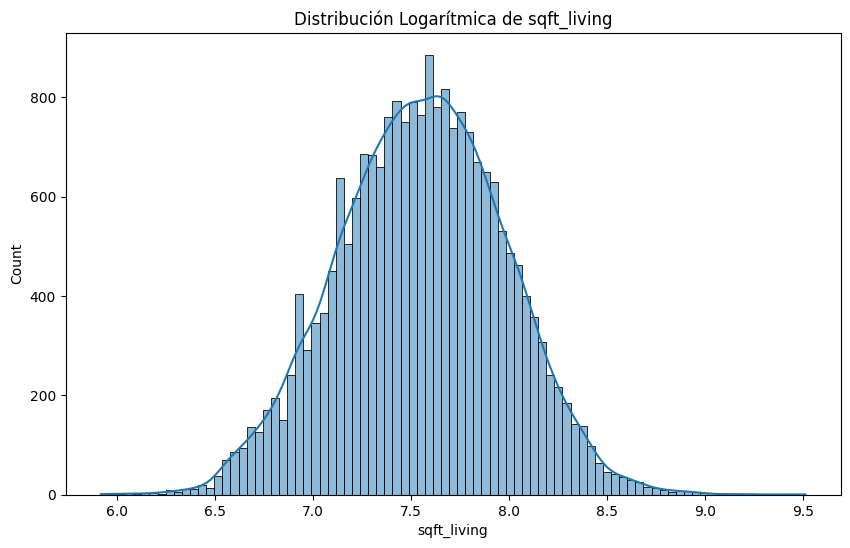

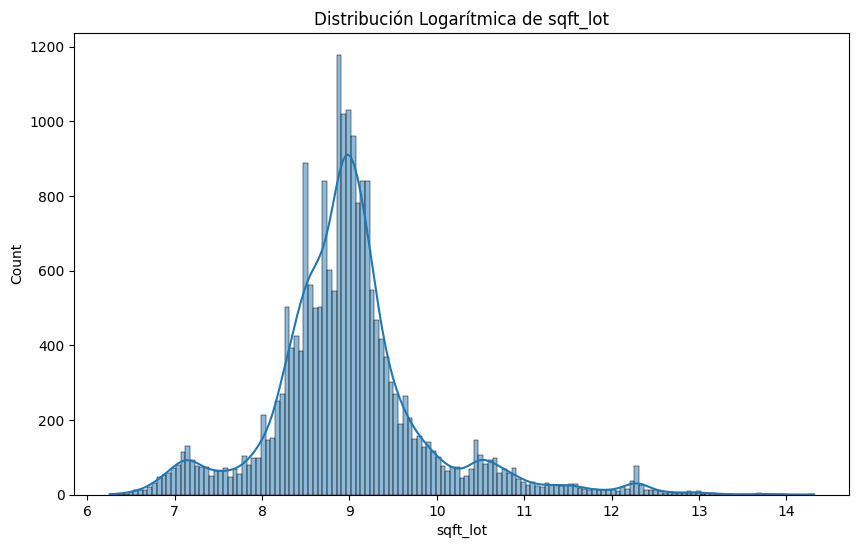

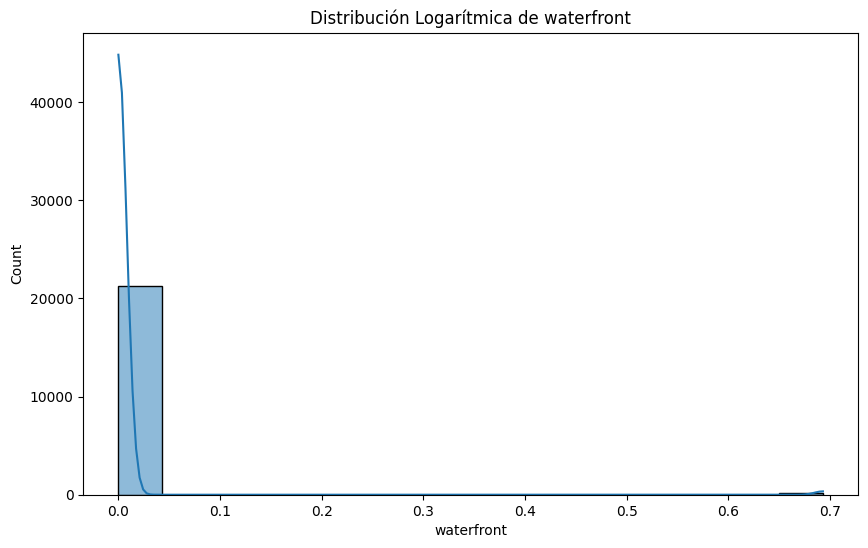

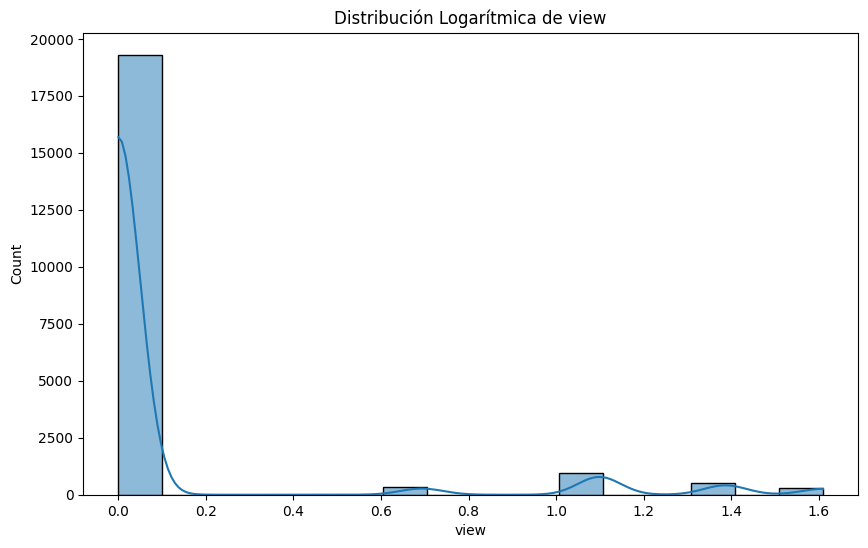

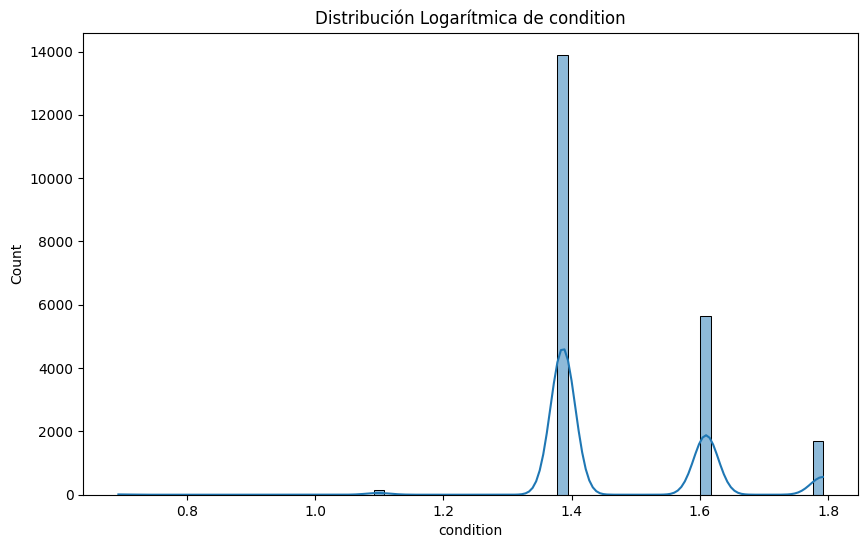

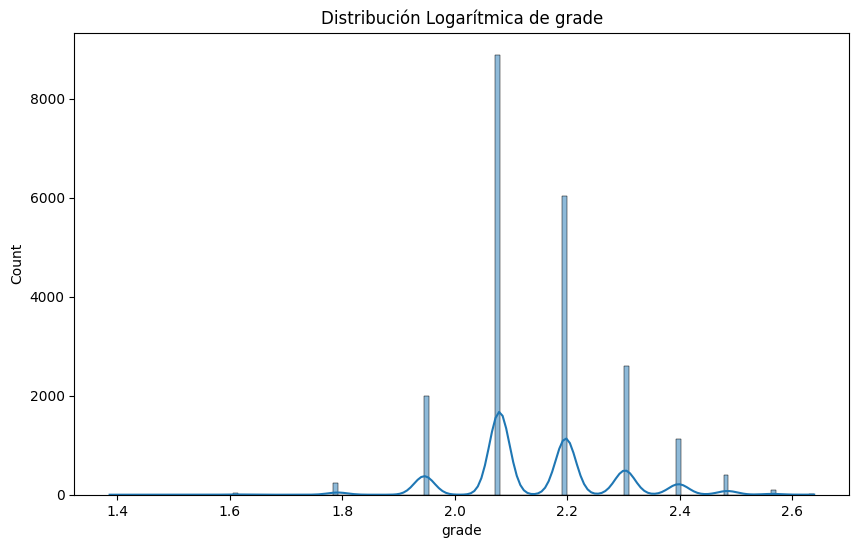

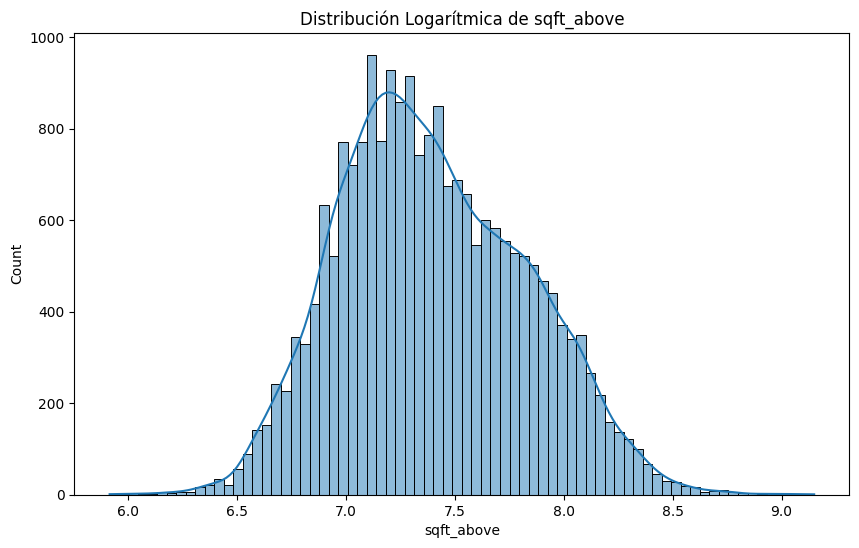

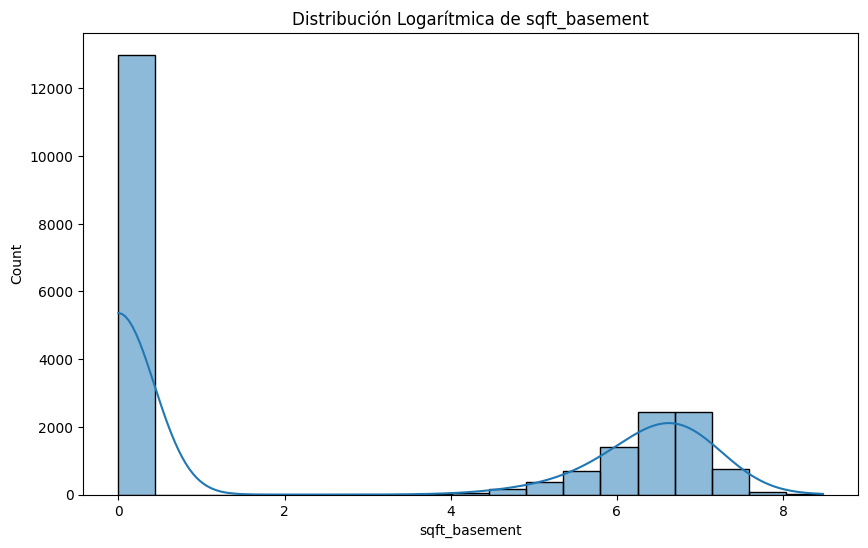

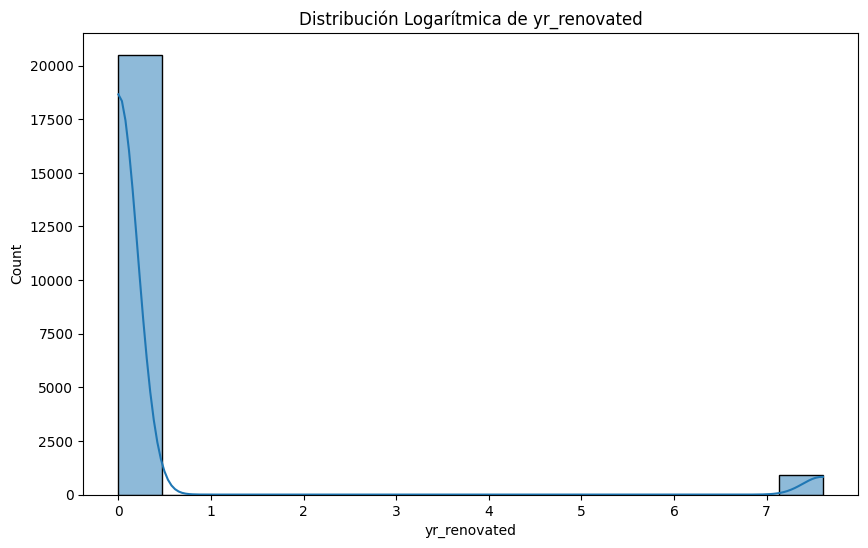

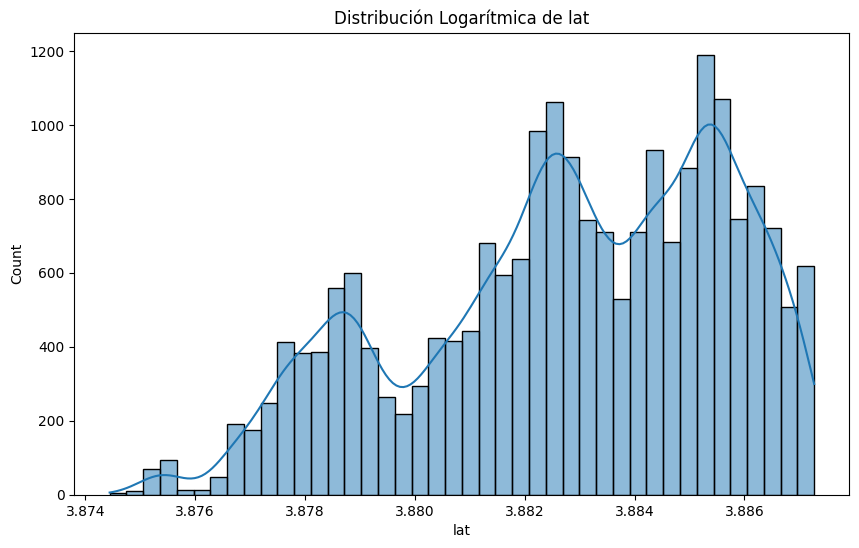

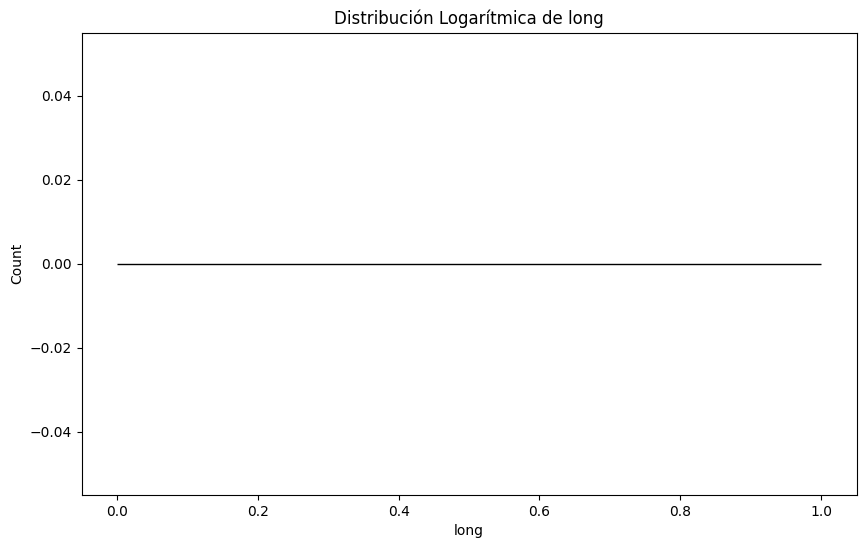

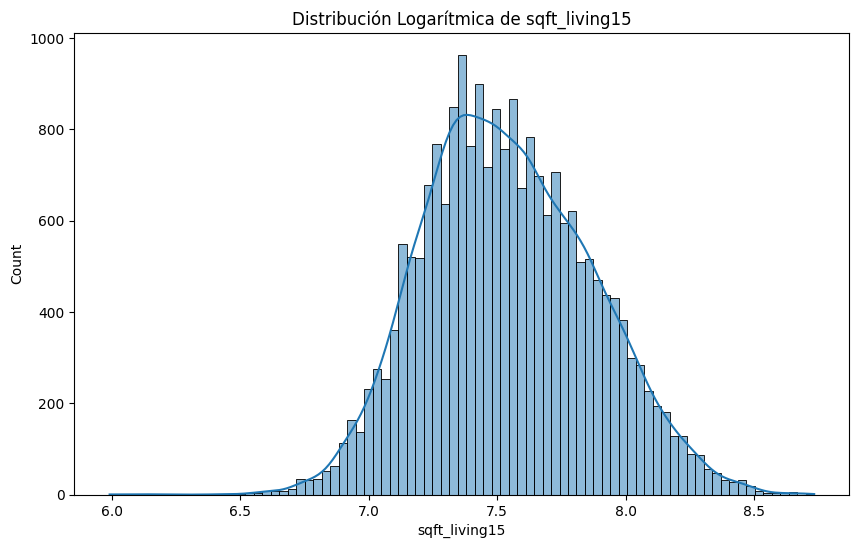

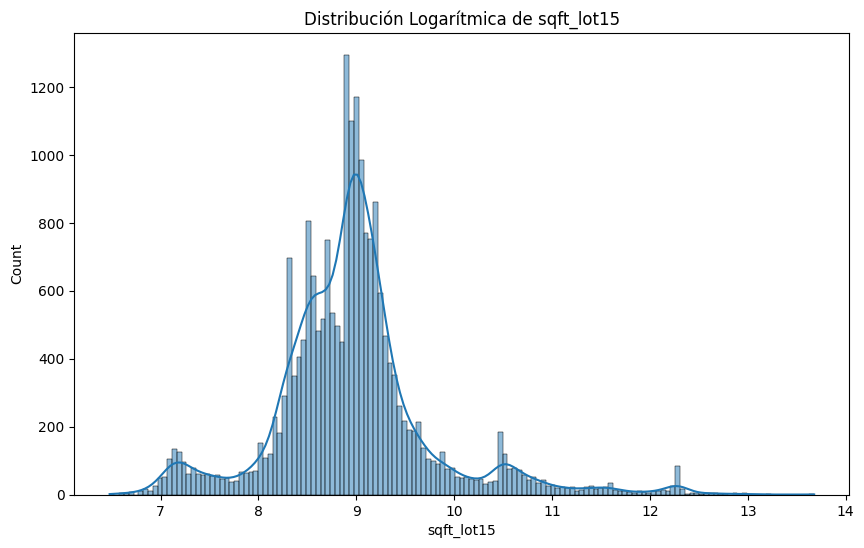

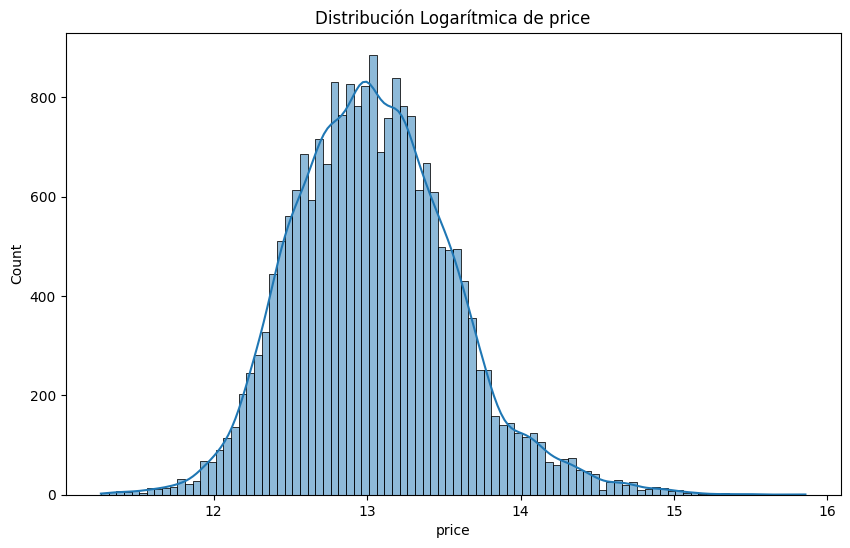

In [11]:
# Copiar el DataFrame original
df_log = df.copy()

# Lista de columnas a transformar
columnas_a_transformar = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                          'waterfront', 'view', 'condition', 'grade', 
                          'sqft_above', 'sqft_basement', 'yr_renovated', 
                          'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']

# Aplicar la transformación logarítmica (añadir 1 para evitar log(0))
for columna in columnas_a_transformar:
    df_log[columna] = np.log1p(df_log[columna])

# Verificar el resultado de la transformación
for columna in columnas_a_transformar:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_log[columna], kde=True)
    plt.title(f'Distribución Logarítmica de {columna}')
    plt.show()


## 5. División de datos y preparación del modelo ##

In [12]:

# Separar características y target
X = df.drop(['price', 'id'], axis=1)
y = np.log1p(df['price'])

# Identificación de características categóricas y numéricas
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Ajustar el preprocesador en todo el conjunto de datos para obtener las características codificadas
preprocessor.fit(X)
encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numerical_features + list(encoded_features)

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## 6. Entrenamiento y evaluación de modelos ##

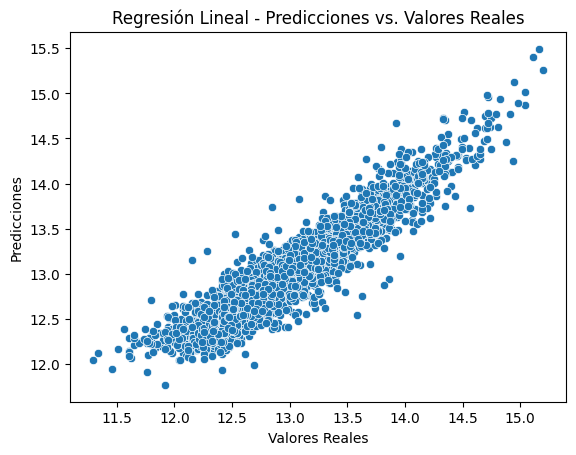

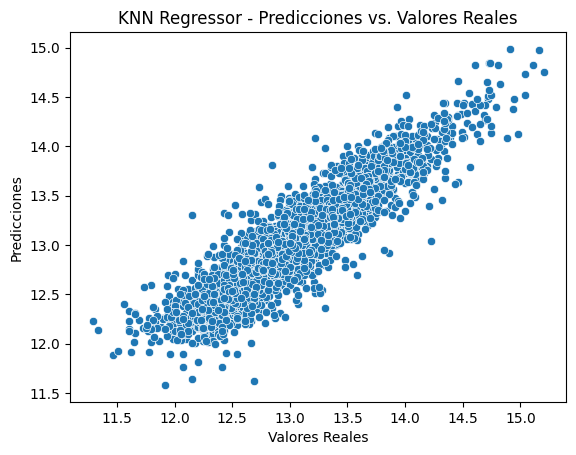

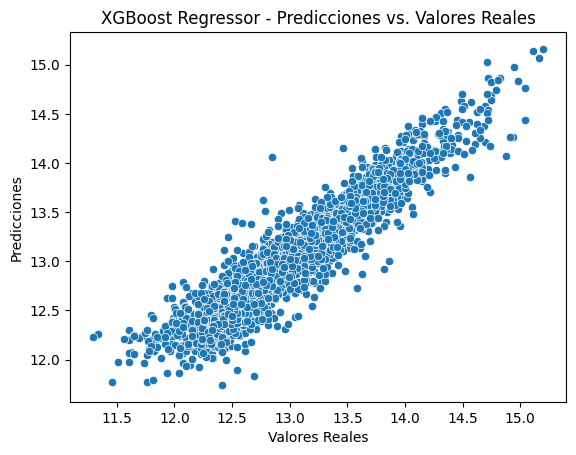

              Modelo       MSE        R²
0   Regresión Lineal  0.035220  0.872168
1      KNN Regressor  0.042500  0.845745
2  XGBoost Regressor  0.029635  0.892439


In [13]:
# Modelos
models = {
    'Regresión Lineal': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(),
    'XGBoost Regressor': xgb.XGBRegressor()
}

# Entrenar y evaluar modelos
results = []
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Modelo': model_name, 'MSE': mse, 'R²': r2})
    plt.figure()
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(f'{model_name} - Predicciones vs. Valores Reales')
    plt.show()

results_df = pd.DataFrame(results)
print(results_df)



#### Regresión Lineal: ####

MSE (Error Cuadrático Medio): 0.035220

R² (Coeficiente de Determinación): 0.872168

La regresión lineal muestra un rendimiento fuerte, con un R² de aproximadamente 0.87. Esto significa que el modelo puede explicar el 87% de la variabilidad en los precios de las viviendas, lo cual es un indicador de un buen ajuste. El MSE es relativamente bajo, lo que sugiere que las predicciones del modelo tienen un error promedio pequeño. La regresión lineal sigue siendo una opción sólida debido a su simplicidad y capacidad de interpretación.

#### KNN Regressor: ####

MSE (Error Cuadrático Medio): 0.042500

R² (Coeficiente de Determinación): 0.845745

El modelo KNN tiene un R² de aproximadamente 0.85, que es un poco menor en comparación con la regresión lineal. Esto indica que el modelo KNN puede explicar el 85% de la variabilidad en los precios de las viviendas. El MSE es mayor que el de la regresión lineal, lo que sugiere que las predicciones de KNN tienen un error promedio mayor. Aunque el KNN puede capturar relaciones no lineales, en este caso, parece que no supera a la regresión lineal en términos de precisión.

#### XGBoost Regressor: ####

MSE (Error Cuadrático Medio): 0.029635

R² (Coeficiente de Determinación): 0.892439

El modelo XGBoost es el mejor de los tres, con el R² más alto de aproximadamente 0.89. Esto indica que XGBoost puede explicar el 89% de la variabilidad en los precios de las viviendas, lo que es el mejor rendimiento entre los modelos evaluados. Además, tiene el MSE más bajo, lo que significa que las predicciones del modelo tienen el menor error promedio. XGBoost demuestra ser el modelo más preciso y robusto para este conjunto de datos.

#### Conclusiones: ####

Mejor Modelo: XGBoost Regressor es el mejor modelo en términos de precisión y capacidad explicativa, con el mayor R² y el menor MSE.

Regresión Lineal: Aunque no es el mejor, la regresión lineal sigue siendo un modelo fuerte con un buen equilibrio entre simplicidad y rendimiento.

KNN Regressor: A pesar de que el modelo KNN es útil para capturar relaciones no lineales, en este caso específico, su rendimiento no supera al de la regresión lineal ni al de XGBoost.

#### Recomendaciones: ####

Optimización de XGBoost: Podemos considerar la optimización adicional de los hiperparámetros de XGBoost para mejorar aún más su rendimiento.

Interpretabilidad: A pesar de que XGBoost es el más preciso, la regresión lineal puede ser preferida en escenarios donde la interpretabilidad es crucial.

Aplicación Práctica: Dada la alta precisión de XGBoost, sería el modelo recomendado para aplicaciones prácticas donde la precisión de las predicciones es prioritaria.


## 7. Optimización del modelo XGBoost ##

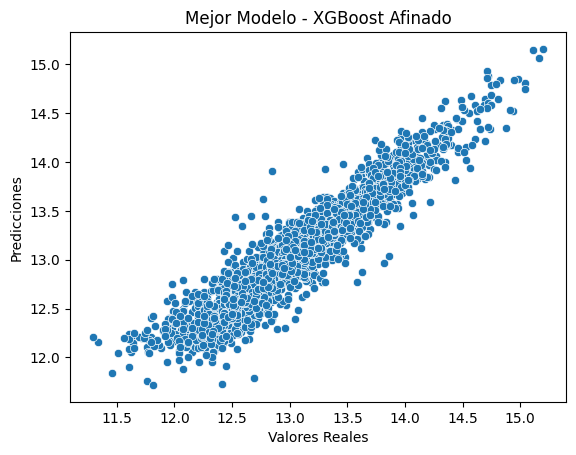

Mejor Modelo XGBoost Afinado - MSE: 0.027118920072485998, R²: 0.9015709648950126


In [14]:

# Definir el grid de hiperparámetros para XGBoost
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5, 7]
}

# Crear el pipeline con el preprocesador y el modelo XGBoost
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', xgb.XGBRegressor())])

# Realizar la búsqueda en el grid
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

# Obtener el mejor modelo
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Graficar los resultados del mejor modelo
plt.figure()
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Mejor Modelo - XGBoost Afinado')
plt.show()

# Evaluar el rendimiento del mejor modelo
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'Mejor Modelo XGBoost Afinado - MSE: {mse_xgb}, R²: {r2_xgb}')


## 8. Análisis de importancia de características ##

<Figure size 1200x800 with 0 Axes>

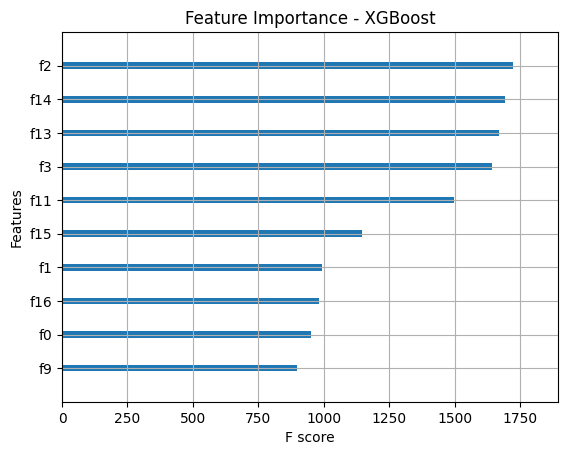

          Feature  Importance
8           grade    0.408312
13            lat    0.101451
2     sqft_living    0.068032
20  zipcode_98004    0.037424
5      waterfront    0.028977
..            ...         ...
18  zipcode_98002    0.000944
52  zipcode_98070    0.000827
31  zipcode_98024    0.000523
29  zipcode_98022    0.000000
56  zipcode_98077    0.000000

[87 rows x 2 columns]


In [15]:
# Obtener la importancia de las características
# Obtener el modelo XGBRegressor del pipeline afinado
xgb_regressor = best_xgb_model.named_steps['model']

# Graficar la importancia de las características con nombres
plt.figure(figsize=(12, 8))
plot_importance(xgb_regressor, max_num_features=10, importance_type='weight', show_values=False)
plt.title('Feature Importance - XGBoost')
plt.show()

# Mostrar los nombres de las características y sus importancias
importances = xgb_regressor.feature_importances_
feature_importances = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

## 9. Interpretación de resultados ##

### Grade: ###

Importancia: 0.408312

Grade parece ser la característica más influyente a la hora de determinar el precio de las viviendas. Hace referencia a la calidad de construcción según los tipos de materiales utilizados y la calidad de la mano de obra.

### Latitud (Lat): ###

Importancia: 0.101451

La latitud del inmueble también juega un papel significativo. Sería aconsejable realizar una cierta investigación sobre la zona: presencia de servicios, vistas, baja criminalidad...

### Superficie habitable (sqft_living): ###

Importancia: 0.068032

No es sorprendente que la superficie habitable de la vivienda sea una característica importante, sobre todo teniendo en cuenta que la concepción del uso del espacio (apuesta por superficies amplias, generalmente como símbolo de estatus) es casi un icono cultural norteamericano.

### Código postal 98004 (zipcode_98004): ###

Importancia: 0.037424

Según los datos disponibles [aquí](https://www.zip-codes.com/zip-code/98004/zip-code-98004.asp), hablamos de una zona muy acomodada, que está por encima de la media condal, estatal y nacional en casi todos los indicadores. Llama la atención la composición étnica, por el alto porcentaje de población asiática. Sería interesante una investigación más profunda.

### Waterfront ###

Importancia: 0.028977

Tener una propiedad frente al lago también añade algo de valor. Probablemente, por motivos estéticos y/o recreativos, así como de exhibición de estatus.

## 10. Análisis de viviendas con precio superior a $650,000 ## 

Para entender qué factores contribuyen a que una vivienda tenga un precio igual o superior a $650,000, realizamos un análisis específico sobre esta segmentación del mercado. Este análisis ayudará a identificar las características comunes entre las viviendas de alto valor y cómo estas características influyen en el precio.

### Distribución de precios ###

Primero, segmentamos el conjunto de datos para obtener solo aquellas viviendas cuyo precio es igual o superior a $650,000:

In [22]:
viviendas_alto_valor= df[df['price'] >= 650000]


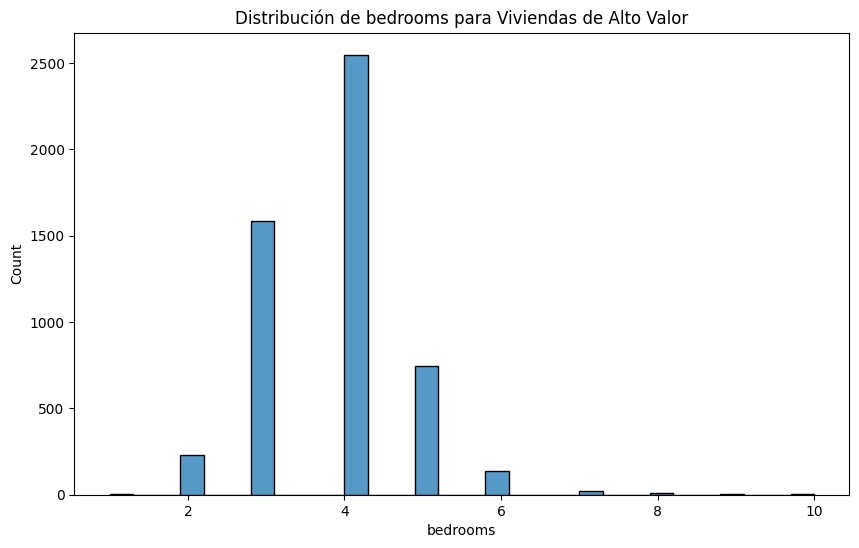

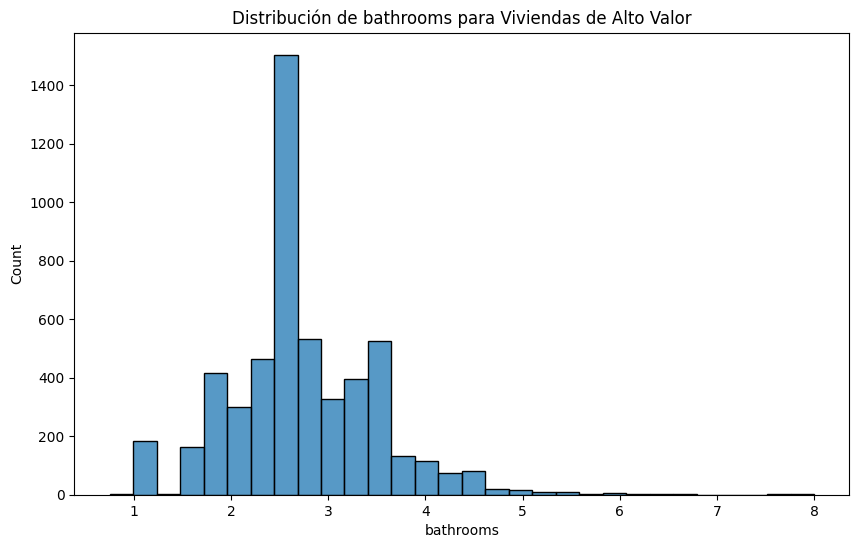

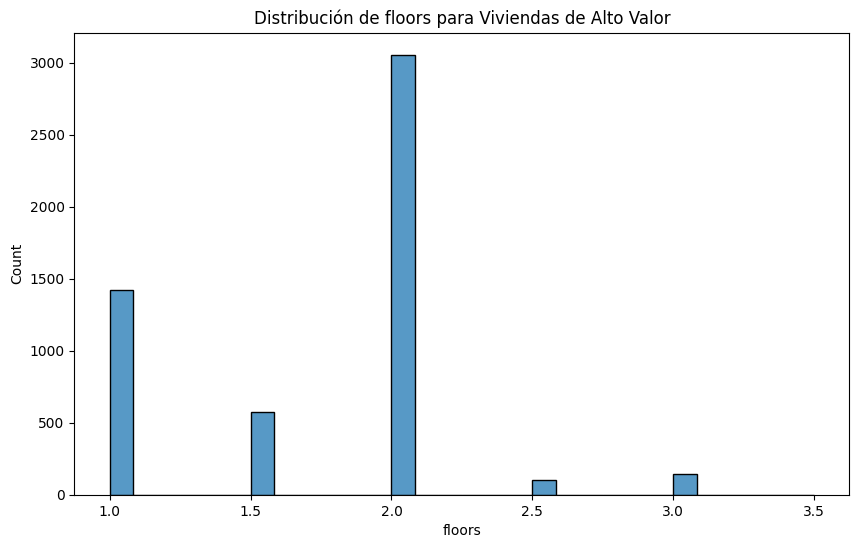

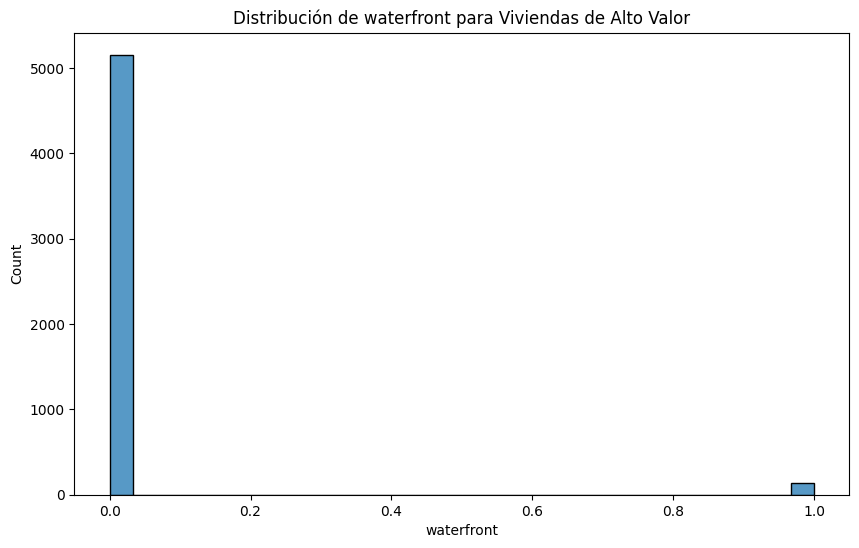

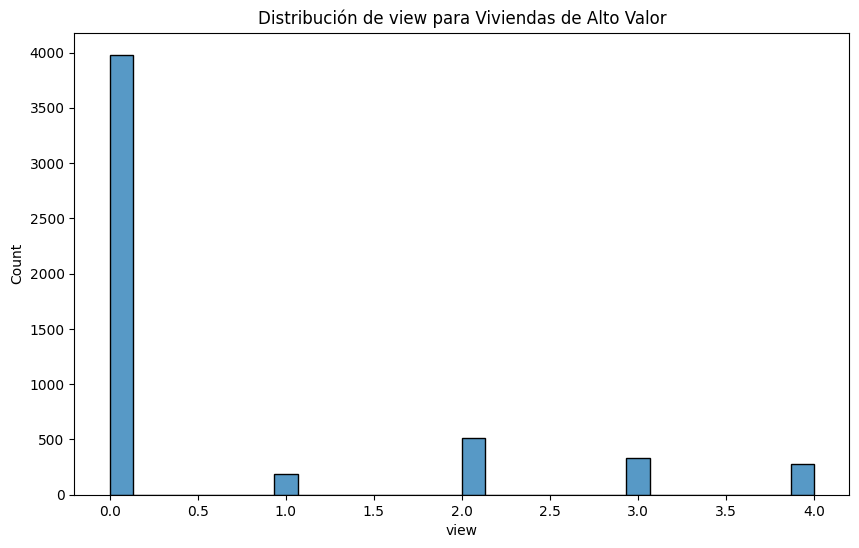

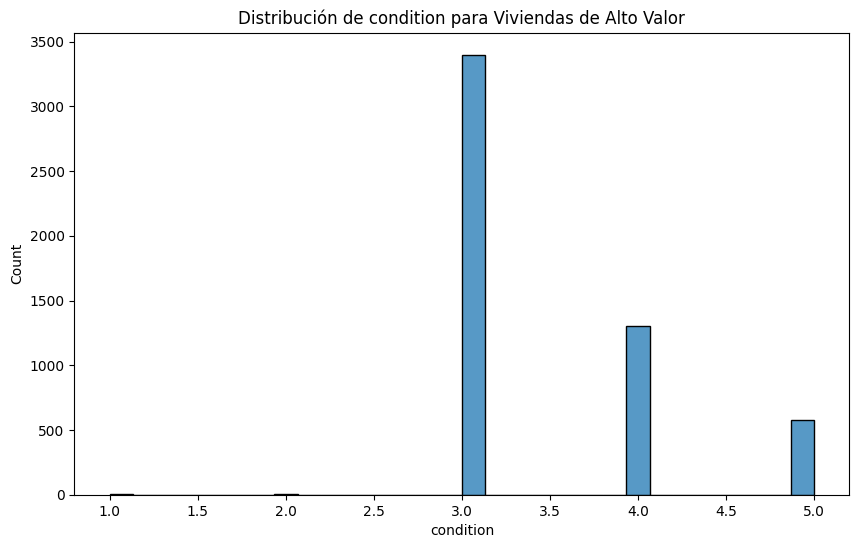

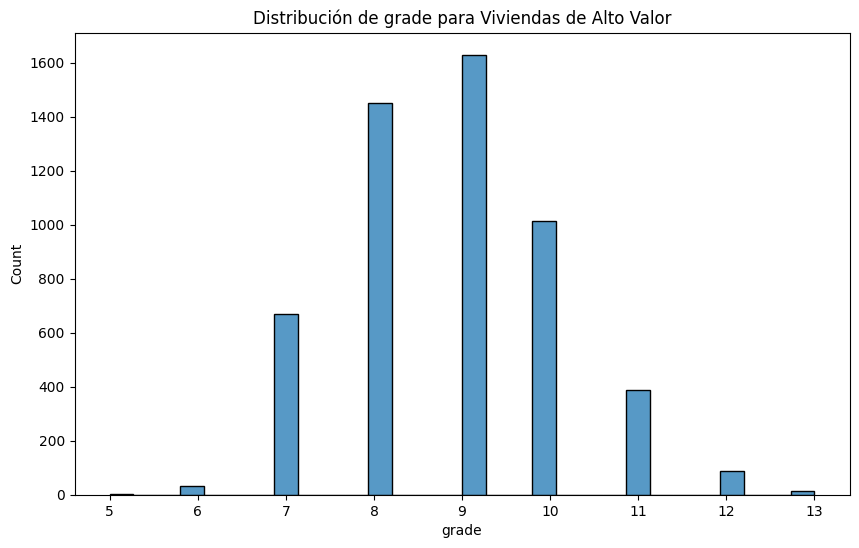

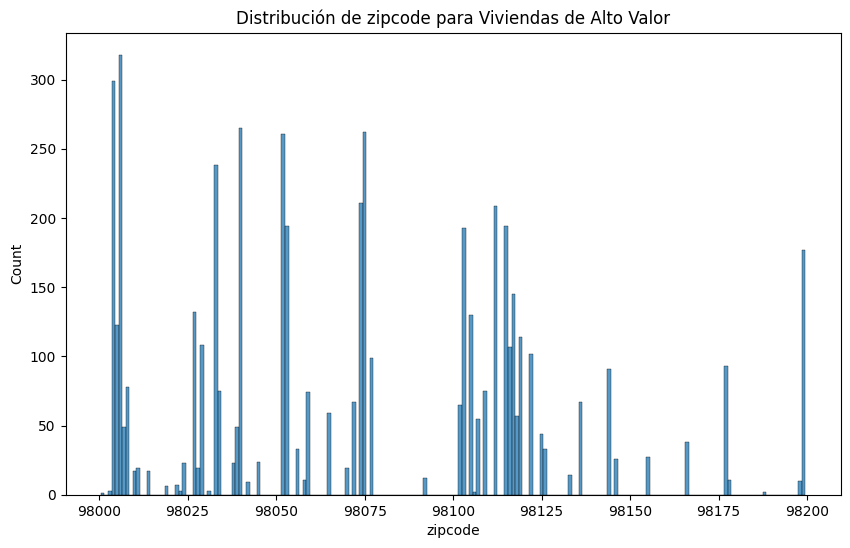

In [32]:
# Análisis de distribuciones para viviendas de alto valor
categorical_features = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=viviendas_alto_valor, x=feature, kde=False, bins=30)
    plt.title(f'Distribución de {feature} para Viviendas de Alto Valor')
    plt.show()

### Matriz de correlación ###

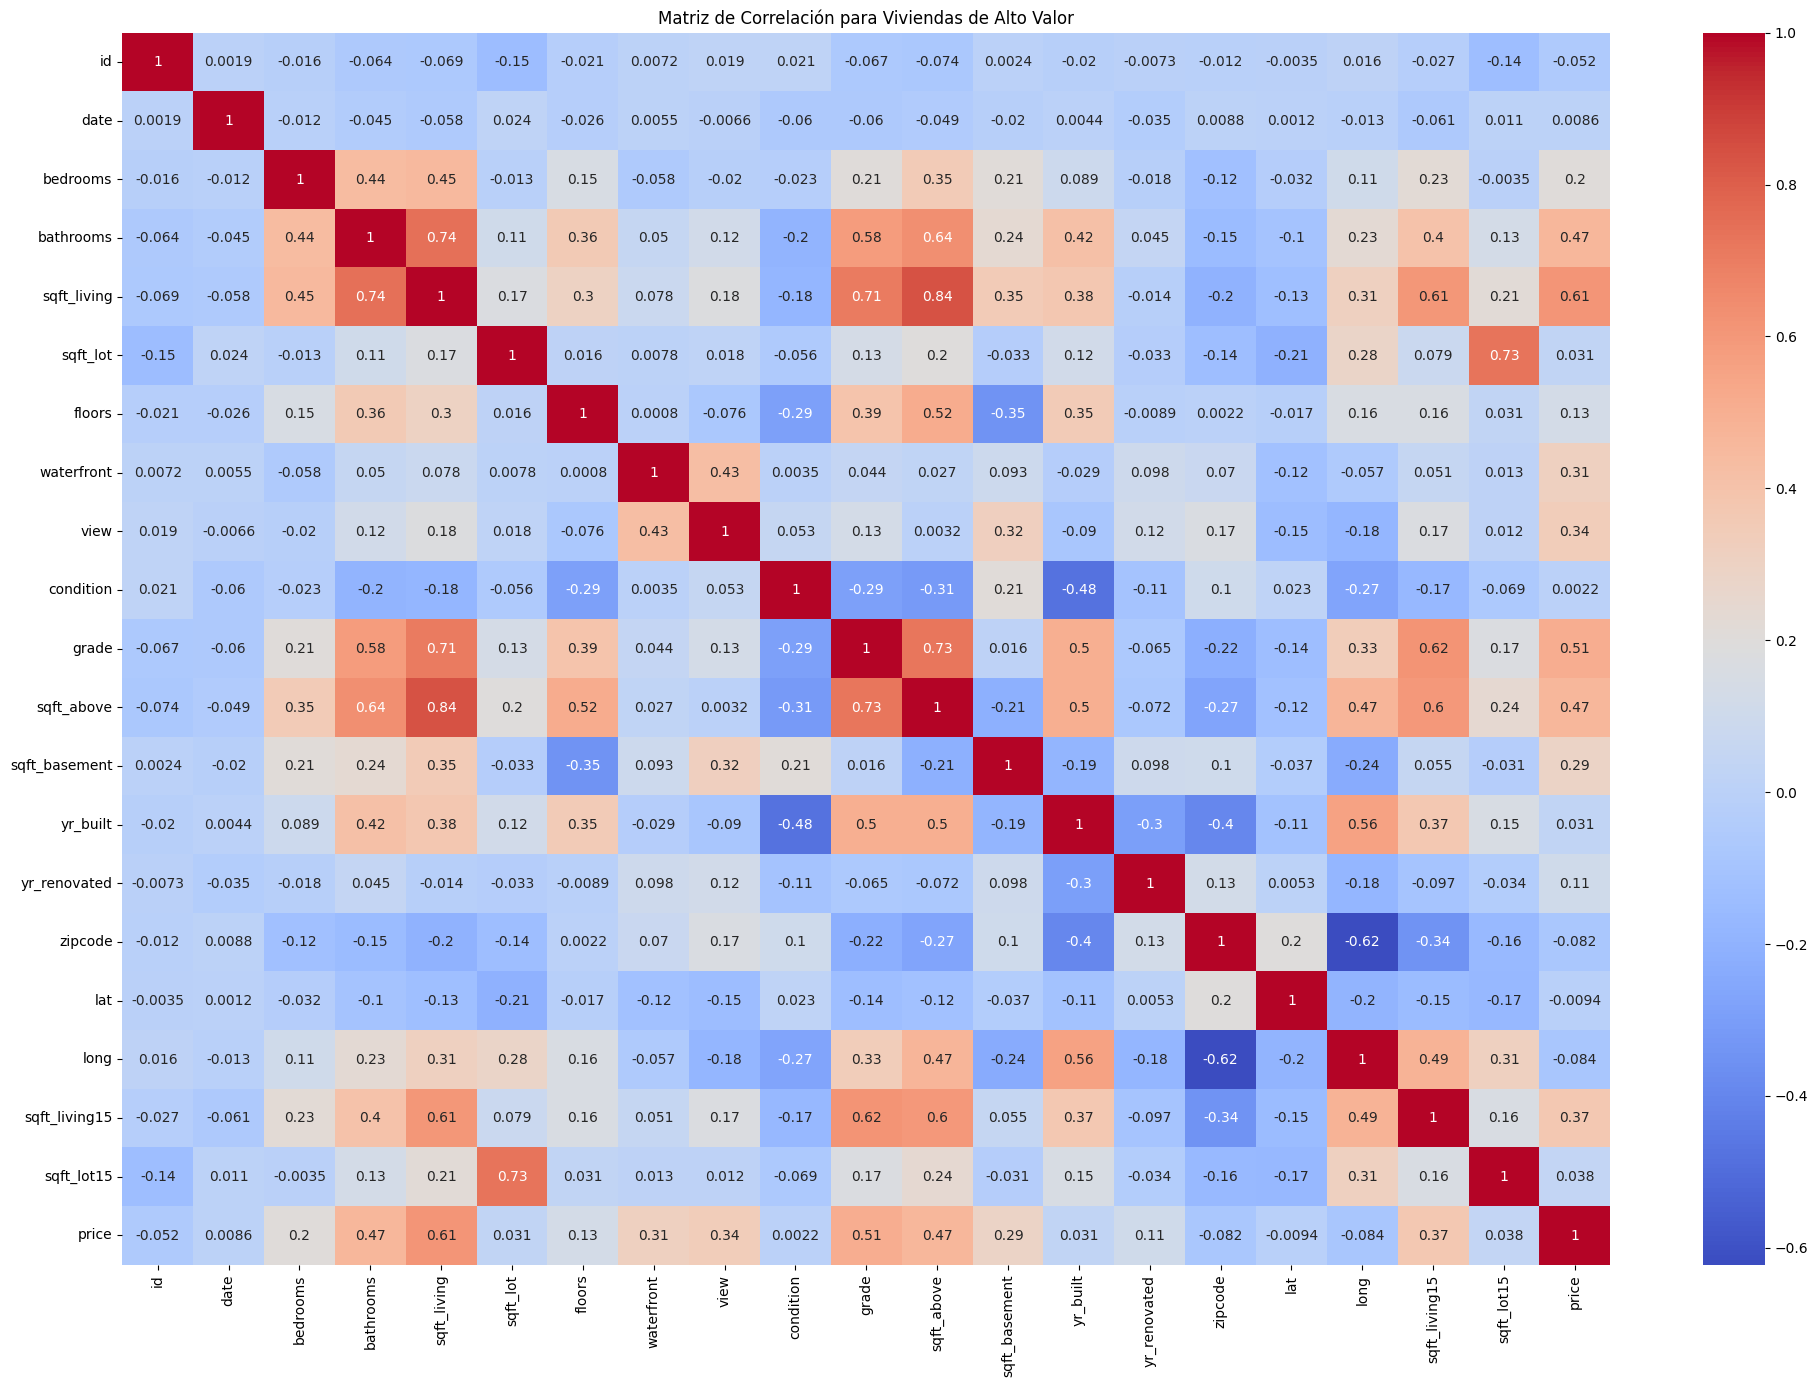

In [33]:
# Análisis de correlación para viviendas de alto valor
correlation_matrix_alto_valor = viviendas_alto_valor.corr()
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix_alto_valor, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación para Viviendas de Alto Valor')
plt.show()

### Interpretación ###

#### Distribuciones de variables categóricas ####

Bedrooms: La mayoría de las viviendas de alto valor tienen 3 o 4 dormitorios.

Bathrooms: La mayoría de las viviendas de alto valor tienen entre 2 y 3 baños.

Floors: La mayoría de las viviendas de alto valor tienen 1 o 2 pisos.

Waterfront: La mayoría de las viviendas de alto valor no tienen vista al agua, pero una pequeña porción significativa sí la tiene.

View: La mayoría de las viviendas de alto valor no tienen una vista especial, pero aquellas que tienen vista, tienden a tener una mejor puntuación.

Condition: La mayoría de las viviendas de alto valor están en condición promedio (3) o superior.

Grade: La calidad de construcción (grade) es generalmente alta, con la mayoría de las viviendas clasificadas entre 8 y 10.

Zipcode: Las viviendas de alto valor están distribuidas en varios códigos postales específicos, con una concentración notable en ciertos códigos.

#### Interpretación de la matriz de correlación ####

sqft_living: Alta correlación positiva con el precio. Indica que la superficie habitable es un factor importante en el precio de las viviendas de alto valor.

grade: Alta correlación positiva con el precio. La calidad de construcción influye significativamente en el precio.

bathrooms: Buena correlación positiva con el precio. El número de baños también es un factor importante.

waterfront: Moderada correlación positiva con el precio. Tener vista al agua aumenta el valor de la propiedad.

sqft_above: Alta correlación positiva con el precio. Similar a la superficie habitable, la superficie sobre el suelo también es relevante.

lat y long: La ubicación geográfica (latitud y longitud) tiene una correlación notable con el precio, lo que sugiere que ciertas áreas tienen propiedades de mayor valor.

### División de datos y preparación del modelo ###

In [42]:
# Crear un subset de las casas con precios iguales o superiores a $650,000
df_high_value = df[df['price'] >= 650000]

# Separar características y target para el subset
X_high_value = df_high_value.drop(['price', 'id'], axis=1)
y_high_value = np.log1p(df_high_value['price'])

# Identificación de características categóricas y numéricas
categorical_features_high_value = X_high_value.select_dtypes(include=['category']).columns.tolist()
numerical_features_high_value = X_high_value.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento para el subset
preprocessor_high_value = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_high_value),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_high_value)
    ])

# División de los datos
X_train_high_value, X_test_high_value, y_train_high_value, y_test_high_value = train_test_split(X_high_value, y_high_value, test_size=0.2, random_state=42)

# Modelos
models_high_value = {
    'Regresión Lineal': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(),
    'XGBoost Regressor': xgb.XGBRegressor()
}





### Entrenamiento y evaluación de los modelos ###

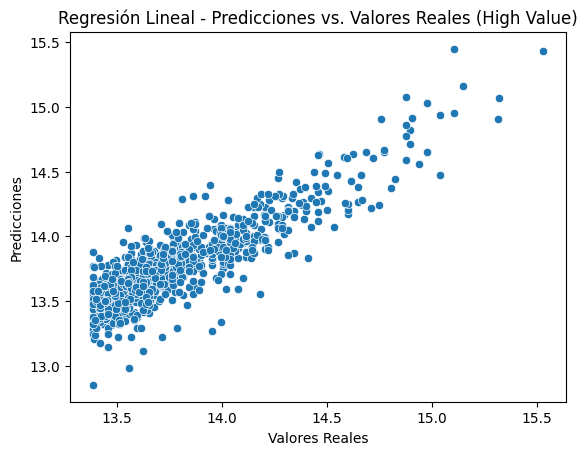

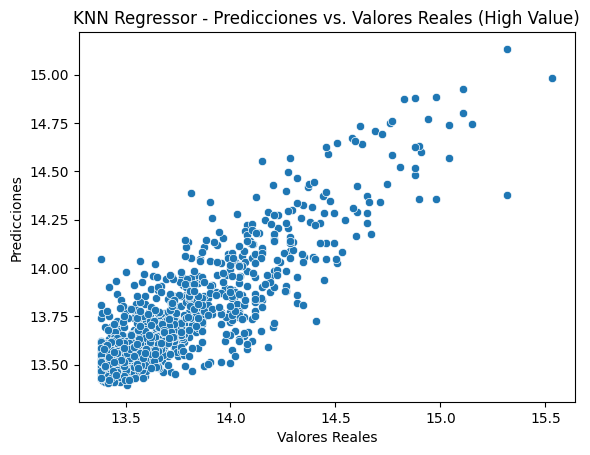

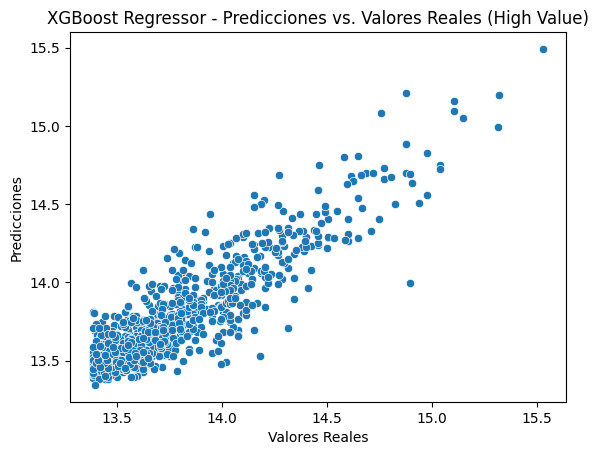

              Modelo       MSE        R²
0   Regresión Lineal  0.025624  0.786247
1      KNN Regressor  0.029642  0.752730
2  XGBoost Regressor  0.021849  0.817738


In [45]:
# Entrenar y evaluar modelos para el subset
results_high_value = []
for model_name, model in models_high_value.items():
    pipeline_high_value = Pipeline(steps=[('preprocessor', preprocessor_high_value),
                                          ('model', model)])
    pipeline_high_value.fit(X_train_high_value, y_train_high_value)
    y_pred_high_value = pipeline_high_value.predict(X_test_high_value)
    mse_high_value = mean_squared_error(y_test_high_value, y_pred_high_value)
    r2_high_value = r2_score(y_test_high_value, y_pred_high_value)
    results_high_value.append({'Modelo': model_name, 'MSE': mse_high_value, 'R²': r2_high_value})
    plt.figure()
    sns.scatterplot(x=y_test_high_value, y=y_pred_high_value)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(f'{model_name} - Predicciones vs. Valores Reales (High Value)')
    plt.show()

results_df_high_value = pd.DataFrame(results_high_value)
print(results_df_high_value)

### Conclusiones del análisis para viviendas de alto valor ###

#### Regresión Lineal: ####

La regresión lineal muestra un buen rendimiento con un R² de aproximadamente 0.79 y un MSE de 0.025624. Esto indica que el modelo puede explicar el 78.62% de la variabilidad en los precios de las viviendas de alto valor. Aunque no es el mejor modelo, la regresión lineal sigue siendo una opción sólida debido a su simplicidad y capacidad de interpretación.

#### KNN Regressor: ####

El modelo KNN tiene un R² de aproximadamente 0.75, lo que indica que puede explicar el 75.27% de la variabilidad en los precios de las viviendas de alto valor. Su MSE es mayor que el de la regresión lineal, lo que sugiere que las predicciones del KNN tienen un error promedio mayor. Aunque el KNN puede capturar relaciones no lineales, en este caso, parece que no supera a la regresión lineal en términos de precisión.

#### XGBoost Regressor: ####

El modelo XGBoost es el mejor de los tres, con el R² más alto de aproximadamente 0.82 y el MSE más bajo de 0.021849. Esto indica que XGBoost puede explicar el 81.77% de la variabilidad en los precios de las viviendas de alto valor, lo que es el mejor rendimiento entre los modelos evaluados. XGBoost demuestra ser el modelo más preciso y robusto para este conjunto de datos.

### Análisis de importancia de características para viviendas de alto valor ###

<Figure size 1200x800 with 0 Axes>

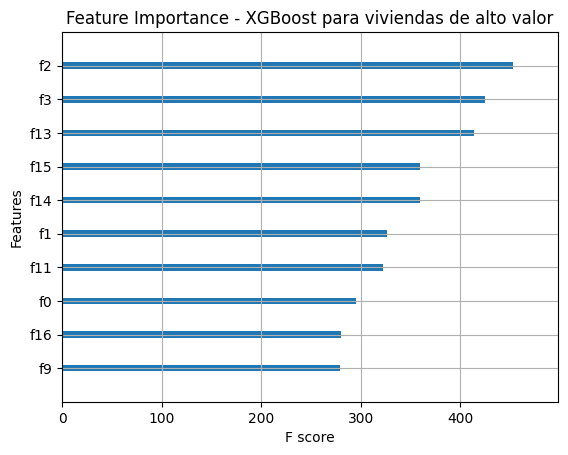

          Feature  Importance
37  zipcode_98039    0.122043
5      waterfront    0.121248
2     sqft_living    0.099388
8           grade    0.094245
14           long    0.061310
..            ...         ...
28  zipcode_98023    0.000000
31  zipcode_98028    0.000000
33  zipcode_98031    0.000000
47  zipcode_98070    0.000000
39  zipcode_98042    0.000000

[78 rows x 2 columns]


In [46]:

# 8. Análisis de importancia de características para viviendas de alto valor

# Entrenar el modelo XGBoost en todo el dataset de alto valor
pipeline_xgb_high_value = Pipeline(steps=[('preprocessor', preprocessor_high_value),
                                          ('model', XGBRegressor())])
pipeline_xgb_high_value.fit(X_train_high_value, y_train_high_value)
xgb_regressor_high_value = pipeline_xgb_high_value.named_steps['model']

# Obtener la importancia de las características
plt.figure(figsize=(12, 8))
plot_importance(xgb_regressor_high_value, max_num_features=10, importance_type='weight', show_values=False)
plt.title('Feature Importance - XGBoost para viviendas de alto valor')
plt.show()

# Mostrar los nombres de las características y sus importancias
importances_high_value = xgb_regressor_high_value.feature_importances_
encoded_features_high_value = preprocessor_high_value.named_transformers_['cat'].get_feature_names_out(categorical_features_high_value)
all_features_high_value = numerical_features_high_value + list(encoded_features_high_value)
feature_importances_high_value = pd.DataFrame({'Feature': all_features_high_value, 'Importance': importances_high_value})
feature_importances_high_value = feature_importances_high_value.sort_values(by='Importance', ascending=False)
print(feature_importances_high_value)


### Características más importantes: ###

#### zipcode_98039 (0.122043): ####

El código postal 98039 corresponde a un área especialmente acomodada, incluso para los ya elevados estánadares del condado, como podemos ver [aquí](https://www.zip-codes.com/zip-code/98039/zip-code-98039.asp). La importancia de este código postal sugiere que la ubicación es un factor crucial en la determinación del precio de las viviendas de alto valor. Las áreas de lujo suelen tener características específicas que las hacen deseables, como proximidad a servicios exclusivos, alta seguridad, vistas panorámicas, etc.

#### waterfront (0.121248): ####

Tener una propiedad frente al agua es una característica muy valorada. Las propiedades con acceso o vista al agua suelen ser más caras debido a su atractivo estético y recreativo. Esto coincide con la importancia alta asignada a esta característica.

#### sqft_living (0.099388): ####

La superficie habitable es siempre un factor determinante en el precio de una vivienda. En el caso de las viviendas de alto valor, una mayor superficie habitable generalmente se traduce en un mayor precio debido a la percepción de lujo y comodidad que ofrecen los espacios más amplios.

#### grade (0.094245): ####

El grado de calidad de la construcción y los acabados es otra característica fundamental. Las viviendas de alto valor suelen tener materiales y acabados de alta calidad, lo que aumenta su precio. Esta característica refleja la calidad y el lujo de la propiedad.

#### long (0.061310): ####

La longitud (longitud geográfica) puede ser un proxy de la ubicación específica dentro de una región más amplia. En áreas metropolitanas o regiones costeras, pequeñas diferencias en longitud pueden implicar diferencias significativas en términos de vistas, proximidad a la costa o al centro de la ciudad, etc.

### Conclusión ####

Las características identificadas como las más importantes por el modelo XGBoost son razonables y reflejan factores que típicamente influyen en el precio de propiedades de alto valor.

Ubicación (zipcode_98039): Refleja la alta demanda y los servicios exclusivos de ciertas áreas.

Vista al agua (waterfront): Aumenta significativamente el valor debido a su atractivo estético.

Superficie habitable (sqft_living): Mayor superficie suele indicar mayor comodidad y lujo.

Calidad de construcción (grade): La calidad de los materiales y los acabados es crucial en propiedades de lujo.

Posición geográfica (long): Puede indicar la proximidad a puntos de interés específicos que afectan el valor de la propiedad.